<a href="https://colab.research.google.com/github/yatishchandrasai/GAN_assignment/blob/main/Hackathon_group06_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING THE REQUIRED MODULES

In [30]:
import pandas as pd
import numpy as np
%matplotlib inline
import os, textwrap
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn import __version__ as sklver
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay,
    classification_report)
import warnings
warnings.filterwarnings("ignore")
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.base import clone
import shap, sys, subprocess
shap.initjs()
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# ---------------------------------------------------------
#  Loading the Data
# ---------------------------------------------------------


In [31]:

datapath = "/content/drive/MyDrive/dataset_B_training.csv"

# Reading the CSV file
train_df = pd.read_csv(datapath)
print("Training shape:", train_df.shape)
print("Columns:", list(train_df.columns))

# Make pandas printouts compact
#pd.set_option("display.max_columns", 30)
#pd.set_option("display.width", 100)

# Targets we expect for Dataset B (train whichever are present)
CANDIDATE_TARGETS = ["h1n1_vaccine"]

train_df.head(5)

Training shape: (4756, 31)
Columns: ['respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa', 'household_adults', 'household_children', 'employment_sector', 'h1n1_vaccine']


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,employment_sector,h1n1_vaccine
0,1,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",2.0,1.0,construction,0
1,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Female,Below Poverty,Not Married,Own,Employed,Non-MSA,0.0,3.0,wholesale,0
2,3,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Female,"> $75,000",Not Married,Own,Employed,"MSA, Principle City",0.0,0.0,real_estate,1
3,4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Female,"<= $75,000, Above Poverty",Not Married,Rent,Not in Labor Force,Non-MSA,0.0,0.0,NaN,0
4,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Female,NaN,Not Married,NaN,Unemployed,Non-MSA,3.0,0.0,NaN,0


In [32]:

# Auto-detect available targets in Dataset B training
available_targets = [t for t in CANDIDATE_TARGETS if t in train_df.columns]
if not available_targets:
    print("\n No target columns found among", CANDIDATE_TARGETS,
          "\n   Please verify your training file includes at least one of them.")
else:
    print("\nDetected target(s):", available_targets)

# ID column (assumed present)
ID_COL = "respondent_id" if "respondent_id" in train_df.columns else None




Detected target(s): ['h1n1_vaccine']


# ---------------------------------------------------------
#  BASIC EDA
# ---------------------------------------------------------

###Quick health checks: types, missingness, class balance.

In [33]:
print("\n-------------- INFO --------------------\n")
print(train_df.info())

print("\n------------- Missing values (top 40) ---------------\n")
missing_counts = train_df.isna().sum().sort_values(ascending=False)
display(missing_counts.head(40))

# If any target exists, show distribution(s)
for tgt in available_targets:
    print(f"\n--------------------- Target distribution: {tgt} -------------\n")
    display(train_df[tgt].value_counts(dropna=False))
    if set(train_df[tgt].dropna().unique()).issubset({0,1}):
      print('\n')
      print(train_df[tgt].value_counts(normalize=True).rename("proportion"))

# Quick look at dtypes
print("\n---------------- dtypes ---------------------\n")
display(train_df.dtypes)



-------------- INFO --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                4756 non-null   int64  
 1   h1n1_concern                 4741 non-null   float64
 2   h1n1_knowledge               4734 non-null   float64
 3   behavioral_antiviral_meds    4739 non-null   float64
 4   behavioral_avoidance         4729 non-null   float64
 5   behavioral_face_mask         4752 non-null   float64
 6   behavioral_wash_hands        4748 non-null   float64
 7   behavioral_large_gatherings  4747 non-null   float64
 8   behavioral_outside_home      4741 non-null   float64
 9   behavioral_touch_face        4736 non-null   float64
 10  doctor_recc_h1n1             4437 non-null   float64
 11  chronic_med_condition        4595 non-null   float64
 12  child_under_6_months         4622

,0
employment_sector,2364
health_insurance,1925
income_poverty,712
doctor_recc_h1n1,319
rent_or_own,315
employment_status,235
marital_status,226
education,224
chronic_med_condition,161
child_under_6_months,134



--------------------- Target distribution: h1n1_vaccine -------------



,count
h1n1_vaccine,
0,2882
1,1874




h1n1_vaccine
0    0.605971
1    0.394029
Name: proportion, dtype: float64

---------------- dtypes ---------------------



,0
respondent_id,int64
h1n1_concern,float64
h1n1_knowledge,float64
behavioral_antiviral_meds,float64
behavioral_avoidance,float64
behavioral_face_mask,float64
behavioral_wash_hands,float64
behavioral_large_gatherings,float64
behavioral_outside_home,float64
behavioral_touch_face,float64


### Separatinng the numerical and Categorical vaiables


In [34]:
# Identify features (exclude id + targets)
feature_cols = [c for c in train_df.columns if c not in ([ID_COL] if ID_COL else []) + available_targets]
print("\n# Features:", len(feature_cols))

# Split features by dtype for preprocessing
cat_cols = [c for c in feature_cols if train_df[c].dtype == "object"]
num_cols = [c for c in feature_cols if train_df[c].dtype != "object"]

print(f"\nCategorical features ({len(cat_cols)}):", cat_cols[:20], ("..." if len(cat_cols) > 20 else ""))
print(f"Numeric features ({len(num_cols)}):", num_cols[:20], ("..." if len(num_cols) > 20 else ""))

# quick numeric summary
print("\n--- Numeric summary ---")
display(train_df[num_cols].describe().T if num_cols else pd.DataFrame({"note": ["no numeric columns detected"]}))


# Features: 29

Categorical features (10): ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa', 'employment_sector'] 
Numeric features (19): ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'household_adults', 'household_children'] 

--- Numeric summary ---


,count,mean,std,min,25%,50%,75%,max
h1n1_concern,4741.0,1.658933,0.892478,0.0,1.0,2.0,2.0,3.0
h1n1_knowledge,4734.0,1.307140,0.612811,0.0,1.0,1.0,2.0,2.0
behavioral_antiviral_meds,4739.0,0.057396,0.232622,0.0,0.0,0.0,0.0,1.0
behavioral_avoidance,4729.0,0.740960,0.438154,0.0,0.0,1.0,1.0,1.0
behavioral_face_mask,4752.0,0.077652,0.267651,0.0,0.0,0.0,0.0,1.0
behavioral_wash_hands,4748.0,0.842039,0.364743,0.0,1.0,1.0,1.0,1.0
behavioral_large_gatherings,4747.0,0.359385,0.479871,0.0,0.0,0.0,1.0,1.0
behavioral_outside_home,4741.0,0.341278,0.474189,0.0,0.0,0.0,1.0,1.0
behavioral_touch_face,4736.0,0.704814,0.456174,0.0,0.0,1.0,1.0,1.0
doctor_recc_h1n1,4437.0,0.290286,0.453946,0.0,0.0,0.0,1.0,1.0


# ---------------------------------------------------------
# PREPROCESSING (minimal, baseline-friendly)
####    - Numeric: median impute
####    - Categorical: most_frequent impute + one-hot encode
####      (OneHotEncoder flags differ across scikit-learn versions → handled below)
# ---------------------------------------------------------

In [35]:
# Creating the median and mode imputing pipelines for numerical and categorical variables
major, minor = map(int, sklver.split(".")[:2])
use_legacy_flag = (major, minor) < (1, 2)   # True for scikit-learn < 1.2

ohe_kwargs = {"handle_unknown": "ignore"}
if use_legacy_flag:
    ohe_kwargs["sparse"] = False            # old API
else:
    ohe_kwargs["sparse_output"] = False     # new API

# For numerical columns imputation
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# For Categorical columns imputation
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(**ohe_kwargs))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop"
)


# getting the one-hot encoders.
def get_ohe_feature_names(preprocessor, cat_cols):
    """
    Version-safe retrieval of OHE output feature names.
    """
    if not cat_cols:
        return []
    ohe = preprocessor.named_transformers_["cat"]["ohe"]
    # Try new API first
    if hasattr(ohe, "get_feature_names_out"):
        return list(ohe.get_feature_names_out(cat_cols))
    # Fallback for very old versions
    if hasattr(ohe, "get_feature_names"):
        return list(ohe.get_feature_names(cat_cols))
    # Last resort: generic names
    return [f"{col}_encoded_{i}" for col in cat_cols for i in range(1000)]  # overshoot guard (won't be used fully)


# ---------------------------------------------------------
#  BASELINE MODEL: RandomForestClassifier
###    We'll train a separate RF for each available target.
# ---------------------------------------------------------


BASELINE: RandomForestClassifier for target: h1n1_vaccine

Metrics [h1n1_vaccine]
Accuracy  : 0.7458
Precision : 0.7059
Recall    : 0.6080
F1-score  : 0.6533
ROC-AUC   : 0.7957

Classification report:
              precision    recall  f1-score   support

           0     0.7663    0.8354    0.7993       577
           1     0.7059    0.6080    0.6533       375

    accuracy                         0.7458       952
   macro avg     0.7361    0.7217    0.7263       952
weighted avg     0.7425    0.7458    0.7418       952



<Figure size 768x576 with 0 Axes>

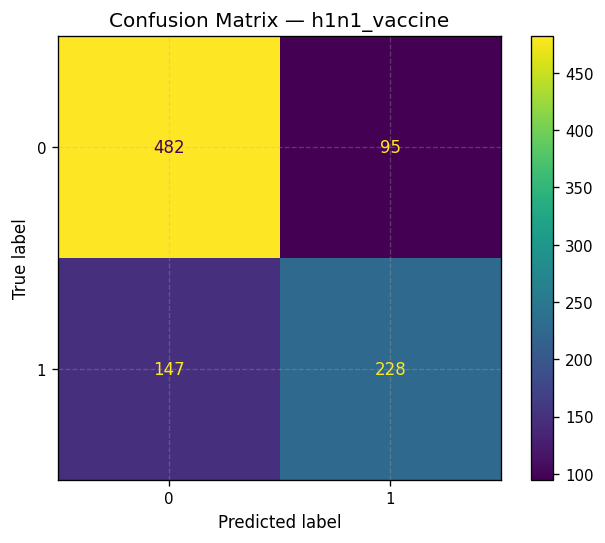

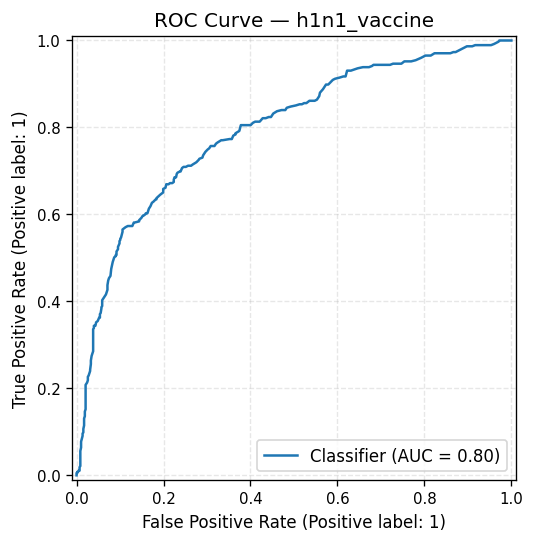


Top 30 features by importance — h1n1_vaccine


,feature,importance
9,doctor_recc_h1n1,0.106958
15,opinion_h1n1_risk,0.093356
14,opinion_h1n1_vacc_effective,0.086670
16,opinion_h1n1_sick_from_vacc,0.040282
0,h1n1_concern,0.038259
1,h1n1_knowledge,0.029133
17,household_adults,0.028228
18,household_children,0.025815
12,health_worker,0.023300
10,chronic_med_condition,0.018698


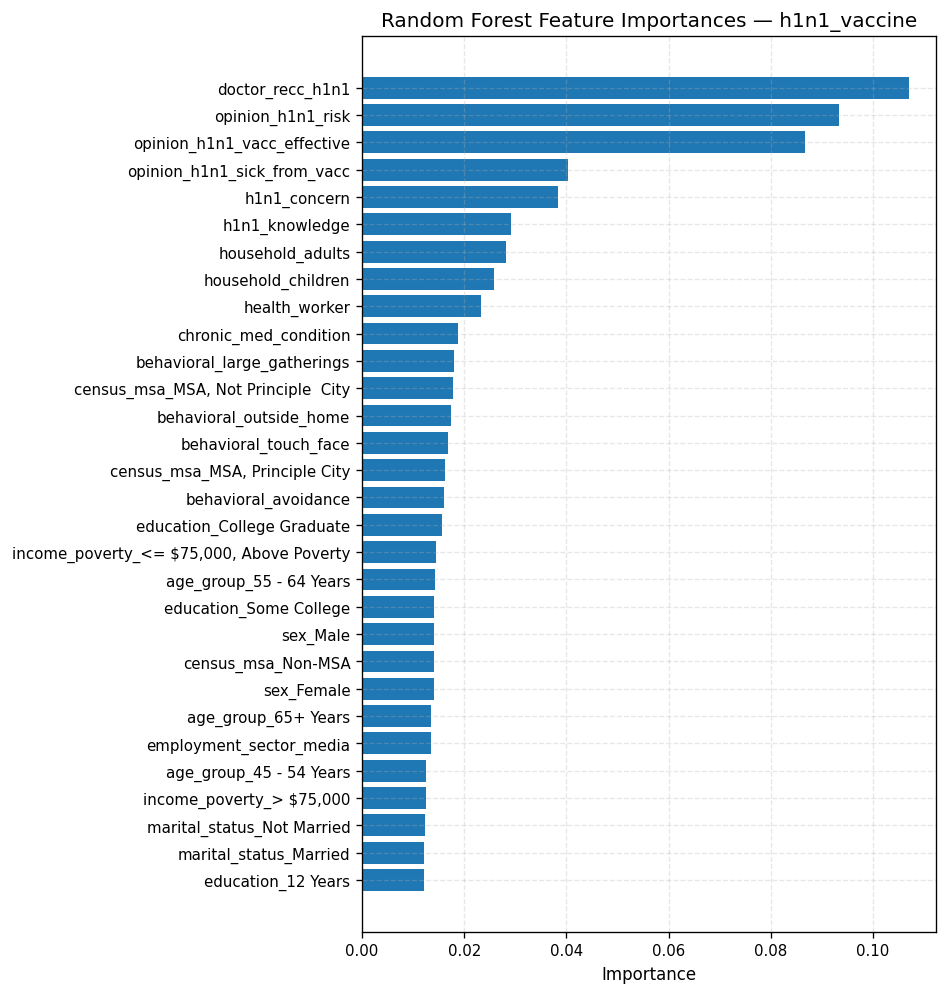

In [36]:

results = []
target = available_targets
for target in available_targets:
    print("\n" + "="*78)
    print(f"BASELINE: RandomForestClassifier for target: {target}")
    print("="*78)

    # Drop rows with target NaN (if any)
    data = train_df.dropna(subset=[target]).copy()
    if data.empty:
        print(f"Skipping {target}: no non-NaN labels found.")
        continue

    X = data[feature_cols]
    y = data[target].astype(int)  # ensure binary int

    # Stratified split to preserve class balance
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Baseline RF (simple; tune later if needed)
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )

    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", rf)
    ])

    # Fit
    pipe.fit(X_train, y_train)

    # Predict
    y_pred  = pipe.predict(X_val)
    y_proba = pipe.predict_proba(X_val)[:, 1]

    # Metrics
    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec  = recall_score(y_val, y_pred, zero_division=0)
    f1   = f1_score(y_val, y_pred, zero_division=0)

    # ROC-AUC (guard if only one class)
    try:
        auc  = roc_auc_score(y_val, y_proba)
    except ValueError:
        auc = np.nan

    print(f"\nMetrics [{target}]")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC-AUC   : {auc:.4f}")

    print("\nClassification report:")
    print(classification_report(y_val, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {target}")
    plt.show()

    # ROC Curve
    try:
        RocCurveDisplay.from_predictions(y_val, y_proba)
        plt.title(f"ROC Curve — {target}")
        plt.show()
    except ValueError:
        pass

    # -----------------------------------------------------
    #  Feature Importances (approximate)
    #     Get feature names after preprocessing, then RF importances
    # -----------------------------------------------------
    # Fit a preprocessing-only transformer to learn OHE categories
    preprocessor.fit(X_train)

    out_num_names = num_cols
    out_cat_names = get_ohe_feature_names(preprocessor, cat_cols)
    out_feature_names = out_num_names + out_cat_names

    # Retrieve fitted RF from pipeline
    fitted_rf = pipe.named_steps["clf"]
    importances = fitted_rf.feature_importances_

    # Align lengths (just in case)
    k = min(len(importances), len(out_feature_names))
    fi_df = pd.DataFrame({
        "feature": out_feature_names[:k],
        "importance": importances[:k]
    }).sort_values("importance", ascending=False).head(30)

    print(f"\nTop 30 features by importance — {target}")
    display(fi_df)

    # Plot top importances
    plt.figure(figsize=(8, max(4, len(fi_df) * 0.28)))
    plt.barh(fi_df["feature"][::-1], fi_df["importance"][::-1])
    plt.title(f"Random Forest Feature Importances — {target}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # Save results summary
    model_base = 'RF_base model'
    results.append({
        "target": target,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        'model':model_base
    })

In [37]:
# ---------------------------------------------------------
# Results Table (across targets)
# ---------------------------------------------------------
if results:
    res_df = pd.DataFrame(results)
    print("\n=== Baseline Results Summary ===")
    display(res_df.sort_values("roc_auc", ascending=False))
else:
    print("\nNo results to summarize (no targets found or models trained).")


=== Baseline Results Summary ===


,target,accuracy,precision,recall,f1,roc_auc,model
0,h1n1_vaccine,0.745798,0.705882,0.608,0.653295,0.795676,RF_base model


# =========================================================
# EXTRA MODELS: LogReg, GradientBoosting, Tuned RF (+ optional XGBoost)
### Appends to results and prints a combined summary.
# =========================================================

In [38]:

# In case `results` wasn't defined for any reason
try:
    results
except NameError:
    results = []

def transformed_feature_names(preprocessor, num_cols, cat_cols):
    """Fit preprocessor (already fitted above in your RF block) and return output feature names."""
    out_num = num_cols
    out_cat = get_ohe_feature_names(preprocessor, cat_cols)
    return out_num + out_cat

def plot_and_report(y_val, y_pred, y_proba, target, model_name):
    """Common reporting: metrics, classification report, CM, ROC."""
    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec  = recall_score(y_val, y_pred, zero_division=0)
    f1   = f1_score(y_val, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_val, y_proba)
    except ValueError:
        auc = np.nan

    print(f"\n[{model_name}] Metrics — {target}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC-AUC   : {auc:.4f}")

    print("\nClassification report:")
    print(classification_report(y_val, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {target} — {model_name}")
    plt.show()

    # ROC Curve
    try:
        RocCurveDisplay.from_predictions(y_val, y_proba)
        plt.title(f"ROC Curve — {target} — {model_name}")
        plt.show()
    except ValueError:
        pass

    return acc, prec, rec, f1, auc

def feature_ranking_from_model(pipe, X_train, model_name, top_k=30):
    """
    Show feature importance/weights if available (RF/GB: feature_importances_, LR: coef_).
    Uses the global `preprocessor`, `num_cols`, `cat_cols`.
    """
    # Build names from preprocessor fitted earlier
    preprocessor.fit(X_train)
    out_names = transformed_feature_names(preprocessor, num_cols, cat_cols)

    model = pipe.named_steps["clf"]
    fi_df = None

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        k = min(len(importances), len(out_names))
        fi_df = pd.DataFrame({"feature": out_names[:k], "importance": importances[:k]}) \
            .sort_values("importance", ascending=False).head(top_k)
        print(f"\nTop {top_k} features by importance — {model_name}")
        display(fi_df)
        plt.figure(figsize=(8, max(4, len(fi_df) * 0.28)))
        plt.barh(fi_df["feature"][::-1], fi_df["importance"][::-1])
        plt.title(f"Feature Importances — {model_name}")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    elif hasattr(model, "coef_"):
        # For Logistic Regression: magnitude of coefficients
        coefs = np.ravel(model.coef_)
        k = min(len(coefs), len(out_names))
        fi_df = pd.DataFrame({"feature": out_names[:k], "weight": coefs[:k]})
        fi_df["abs_weight"] = fi_df["weight"].abs()
        fi_df = fi_df.sort_values("abs_weight", ascending=False).head(top_k)
        print(f"\nTop {top_k} features by |coefficient| — {model_name}")
        display(fi_df[["feature", "weight", "abs_weight"]])
        plt.figure(figsize=(8, max(4, len(fi_df) * 0.28)))
        plt.barh(fi_df["feature"][::-1], fi_df["abs_weight"][::-1])
        plt.title(f"Top |Coefficients| — {model_name}")
        plt.xlabel("|Coefficient|")
        plt.tight_layout()
        plt.show()
    else:
        print(f"(No feature importance/weights available for {model_name}.)")



# -----------------------------------------
# Define additional models
# -----------------------------------------

In [39]:

models_to_try = [
    ("RandomForest_tuned",
     RandomForestClassifier(
         n_estimators=800,
         max_depth=None,
         min_samples_split=2,
         min_samples_leaf=2,
         class_weight="balanced",
         n_jobs=-1,
         random_state=42
     )),
    ("LogisticRegression",
     LogisticRegression(
         max_iter=1500,
         class_weight="balanced",
         solver="lbfgs"
     )),
    ("GradientBoosting",
     GradientBoostingClassifier(
         random_state=42
     )),
]

# Try to add XGBoost if available
try:
    from xgboost import XGBClassifier
    models_to_try.append((
        "XGBoost",
        XGBClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            n_jobs=-1,
            random_state=42,
            eval_metric="logloss"
        )
    ))
    print(" XGBoost detected — will train it too.")
except Exception as e:
    print(" XGBoost not available — skipping. (Install with: pip install xgboost)")


 XGBoost detected — will train it too.


# -----------------------------------------
# Train/evaluate each model per target
# -----------------------------------------


MODEL ZOO for target: h1n1_vaccine

----------------------------------------------------------------------
Training: RandomForest_tuned

[RandomForest_tuned] Metrics — h1n1_vaccine
Accuracy  : 0.7416
Precision : 0.6787
Recall    : 0.6533
F1-score  : 0.6658
ROC-AUC   : 0.8018

Classification report:
              precision    recall  f1-score   support

           0     0.7800    0.7990    0.7894       577
           1     0.6787    0.6533    0.6658       375

    accuracy                         0.7416       952
   macro avg     0.7294    0.7261    0.7276       952
weighted avg     0.7401    0.7416    0.7407       952



<Figure size 768x576 with 0 Axes>

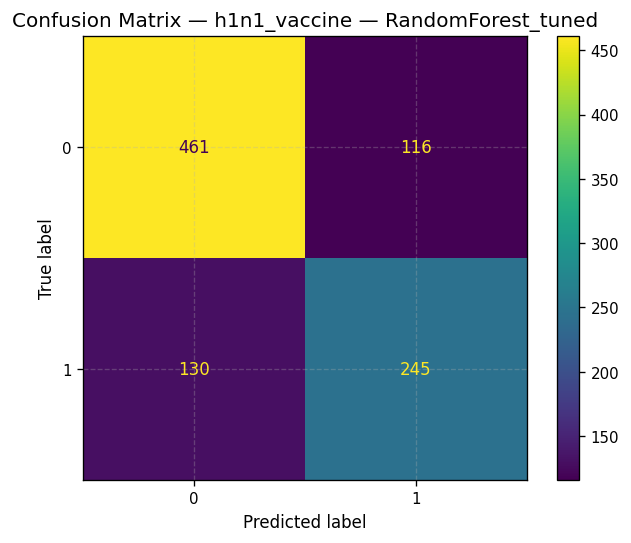

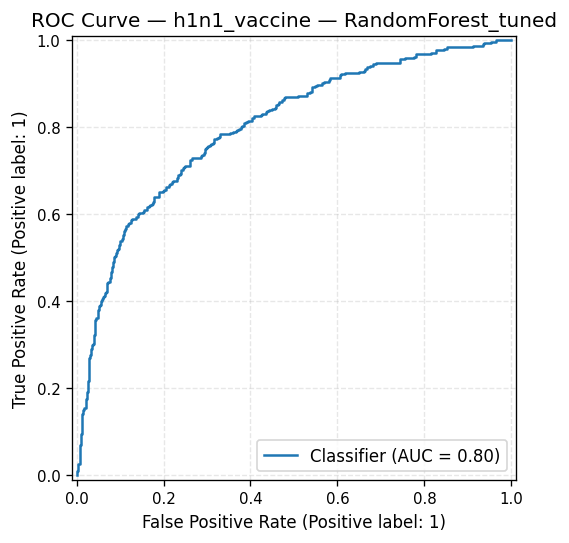


Top 30 features by importance — RandomForest_tuned (h1n1_vaccine)


,feature,importance
9,doctor_recc_h1n1,0.142162
15,opinion_h1n1_risk,0.115244
14,opinion_h1n1_vacc_effective,0.106750
16,opinion_h1n1_sick_from_vacc,0.036757
0,h1n1_concern,0.036074
1,h1n1_knowledge,0.028520
12,health_worker,0.026465
17,household_adults,0.024501
18,household_children,0.023450
10,chronic_med_condition,0.017278


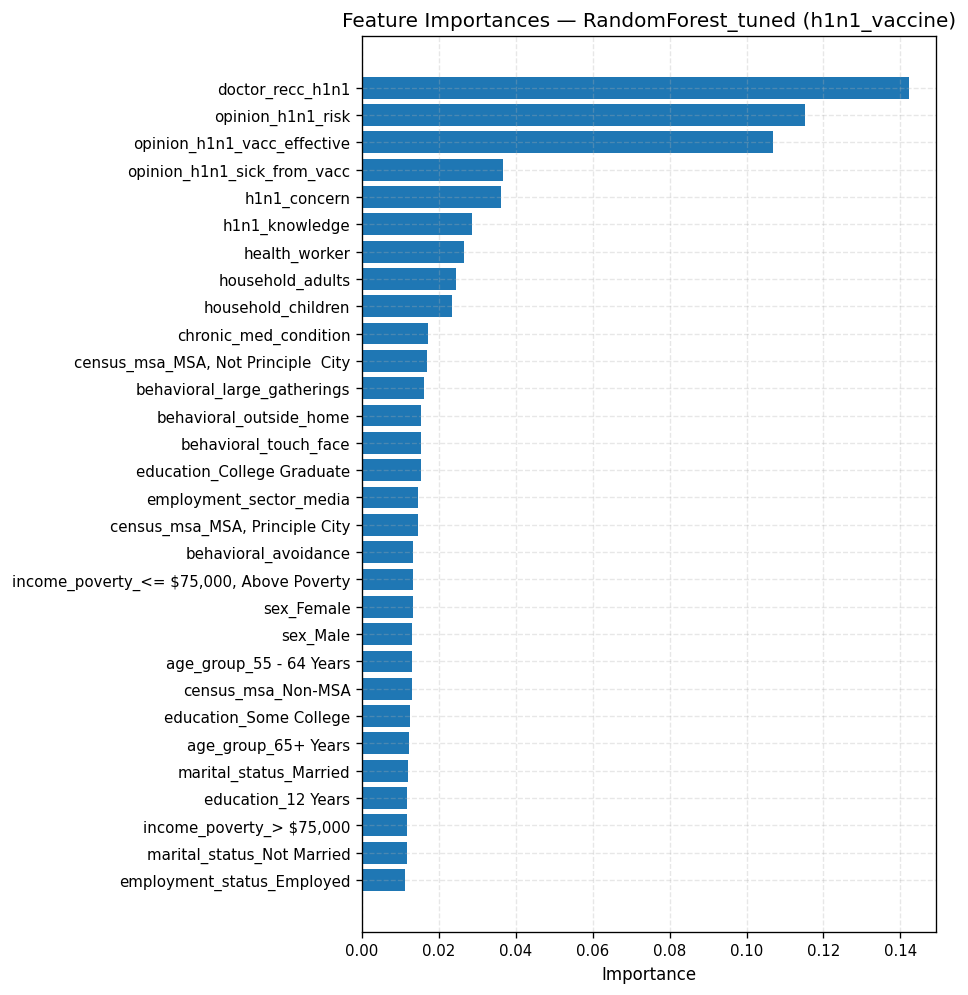


----------------------------------------------------------------------
Training: LogisticRegression

[LogisticRegression] Metrics — h1n1_vaccine
Accuracy  : 0.7416
Precision : 0.6577
Recall    : 0.7173
F1-score  : 0.6862
ROC-AUC   : 0.8157

Classification report:
              precision    recall  f1-score   support

           0     0.8048    0.7574    0.7804       577
           1     0.6577    0.7173    0.6862       375

    accuracy                         0.7416       952
   macro avg     0.7312    0.7373    0.7333       952
weighted avg     0.7468    0.7416    0.7433       952



<Figure size 768x576 with 0 Axes>

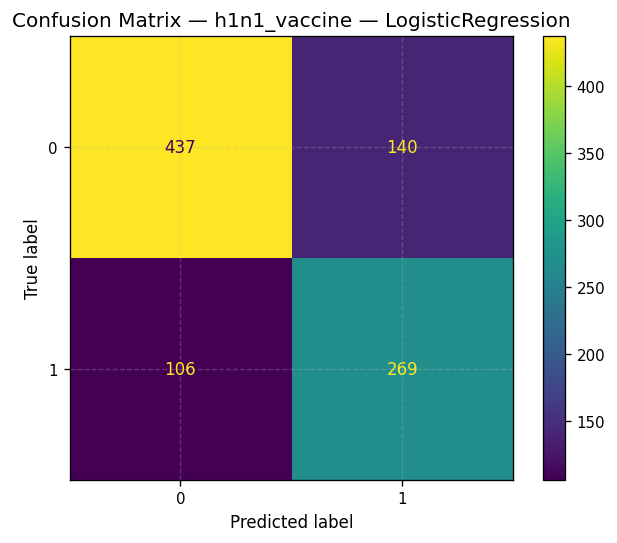

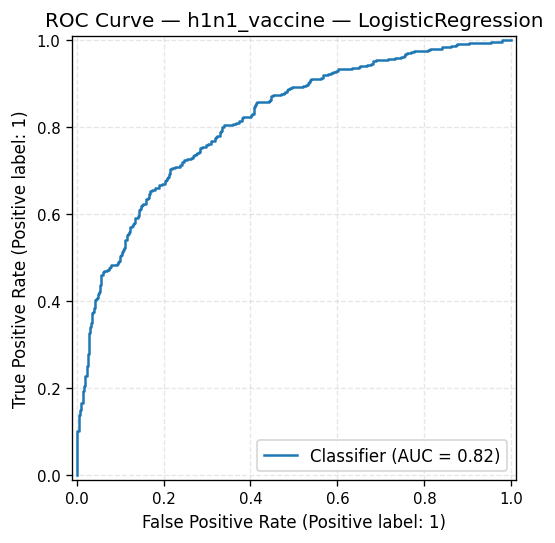


Top 30 features by |coefficient| — LogisticRegression (h1n1_vaccine)


,feature,weight,abs_weight
63,employment_sector_technology,1.749950,1.749950
9,doctor_recc_h1n1,1.673063,1.673063
47,employment_sector_administrative,0.835055,0.835055
12,health_worker,0.699213,0.699213
65,employment_sector_utilities,-0.651953,0.651953
14,opinion_h1n1_vacc_effective,0.636331,0.636331
58,employment_sector_mining,-0.624616,0.624616
56,employment_sector_manufacturing,-0.483430,0.483430
15,opinion_h1n1_risk,0.434736,0.434736
48,employment_sector_agriculture,-0.411659,0.411659


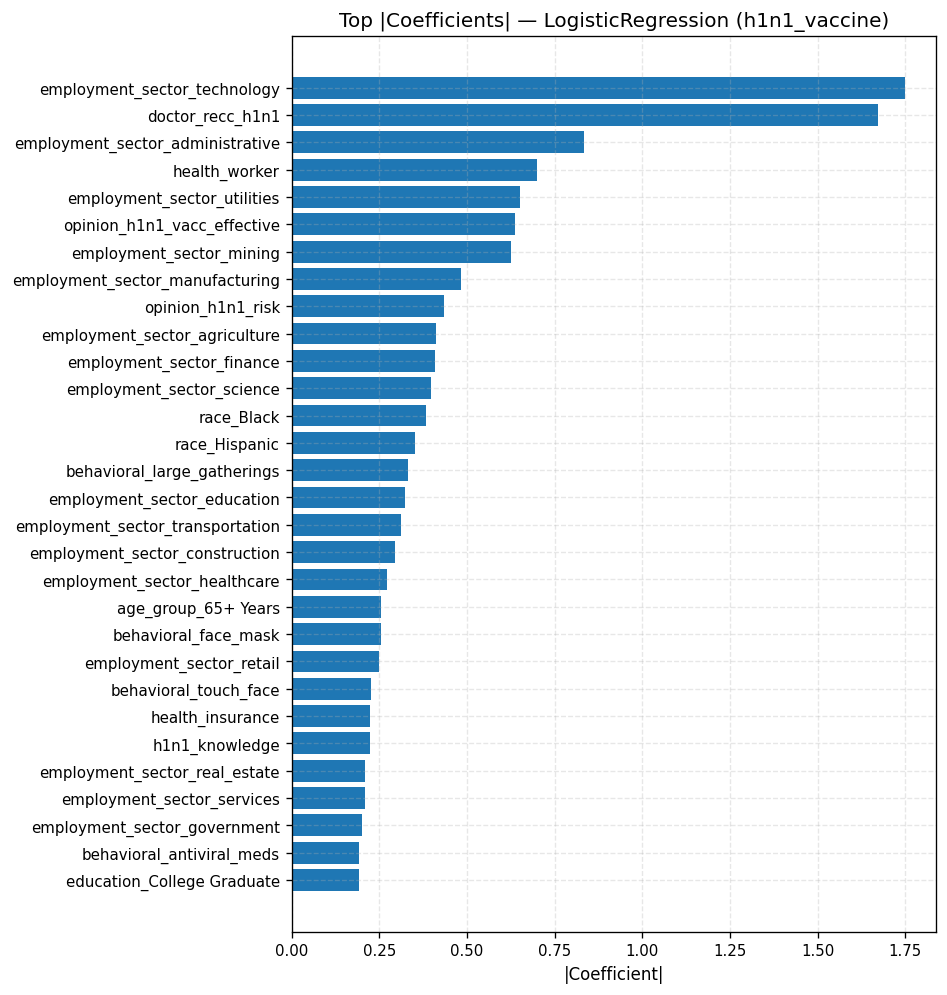


----------------------------------------------------------------------
Training: GradientBoosting

[GradientBoosting] Metrics — h1n1_vaccine
Accuracy  : 0.7616
Precision : 0.7202
Recall    : 0.6453
F1-score  : 0.6807
ROC-AUC   : 0.8107

Classification report:
              precision    recall  f1-score   support

           0     0.7841    0.8371    0.8097       577
           1     0.7202    0.6453    0.6807       375

    accuracy                         0.7616       952
   macro avg     0.7522    0.7412    0.7452       952
weighted avg     0.7589    0.7616    0.7589       952



<Figure size 768x576 with 0 Axes>

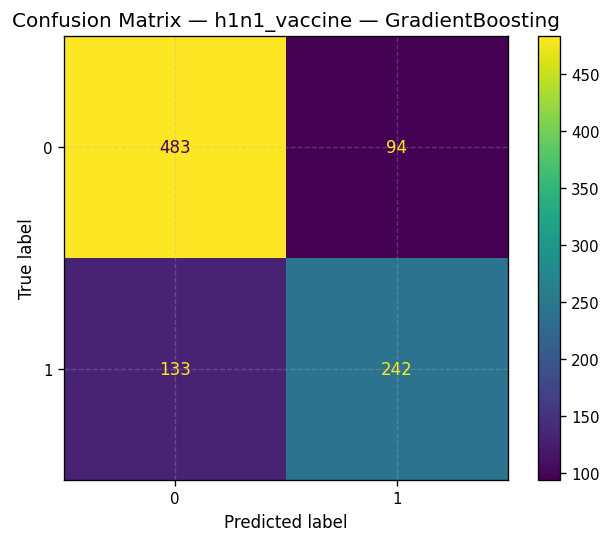

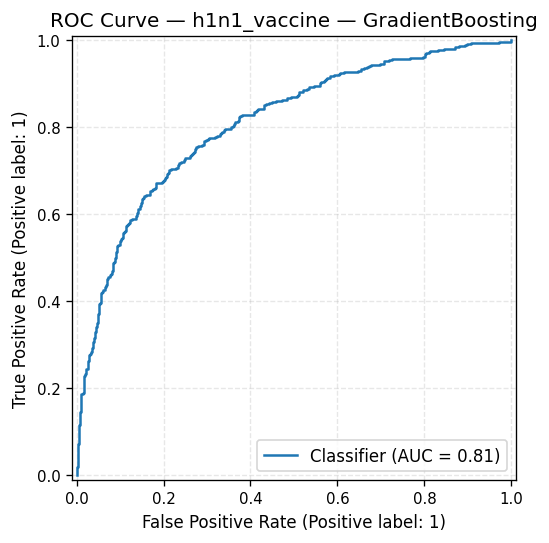


Top 30 features by importance — GradientBoosting (h1n1_vaccine)


,feature,importance
9,doctor_recc_h1n1,0.400309
14,opinion_h1n1_vacc_effective,0.172529
15,opinion_h1n1_risk,0.166475
12,health_worker,0.044022
16,opinion_h1n1_sick_from_vacc,0.019694
1,h1n1_knowledge,0.016212
63,employment_sector_technology,0.012774
17,household_adults,0.011724
23,age_group_65+ Years,0.010462
18,household_children,0.009360


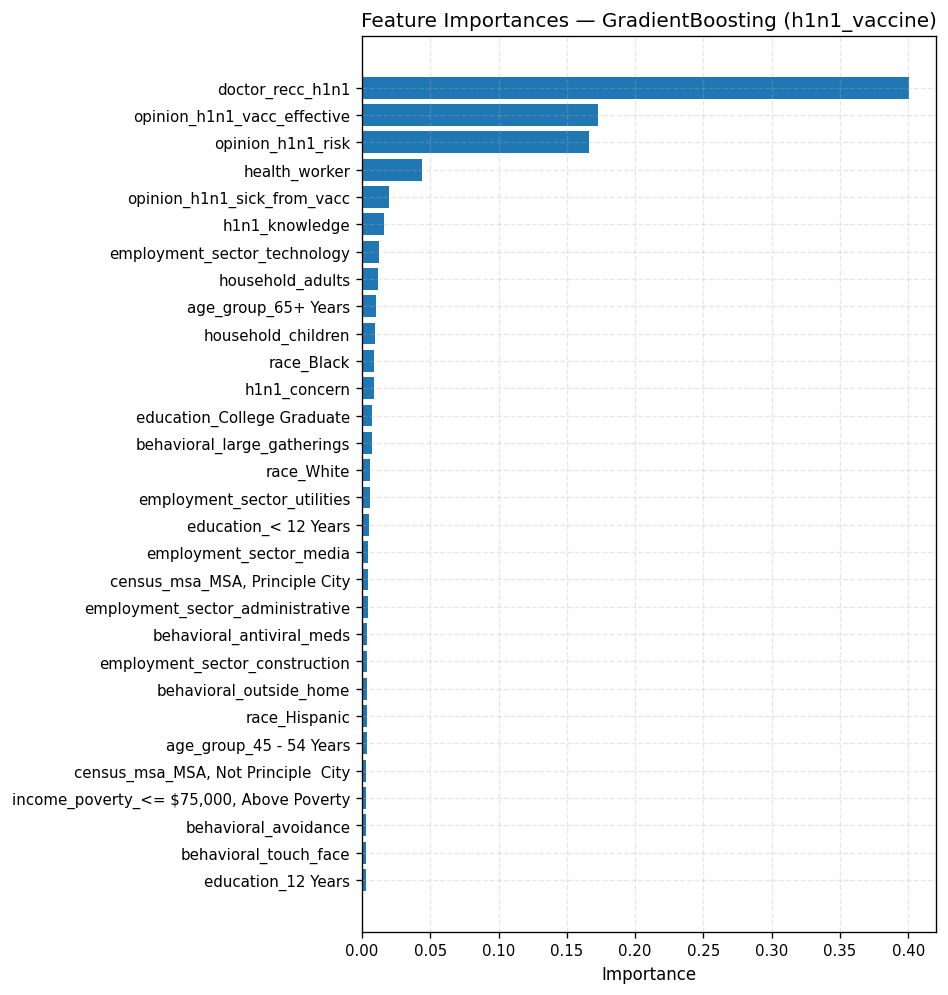


----------------------------------------------------------------------
Training: XGBoost

[XGBoost] Metrics — h1n1_vaccine
Accuracy  : 0.7458
Precision : 0.6905
Recall    : 0.6427
F1-score  : 0.6657
ROC-AUC   : 0.8007

Classification report:
              precision    recall  f1-score   support

           0     0.7778    0.8128    0.7949       577
           1     0.6905    0.6427    0.6657       375

    accuracy                         0.7458       952
   macro avg     0.7342    0.7277    0.7303       952
weighted avg     0.7434    0.7458    0.7440       952



<Figure size 768x576 with 0 Axes>

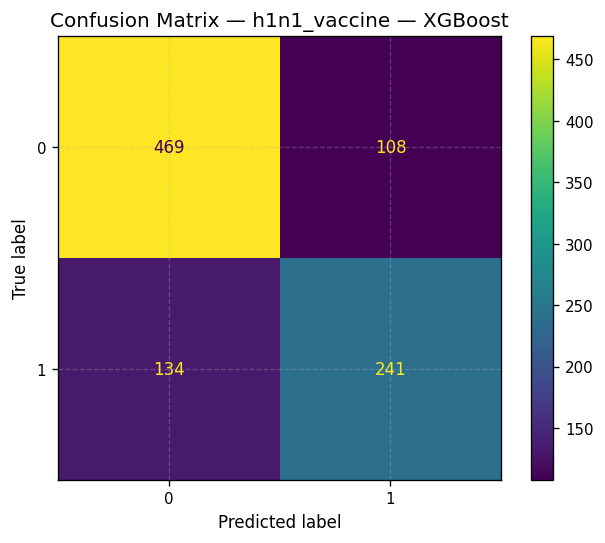

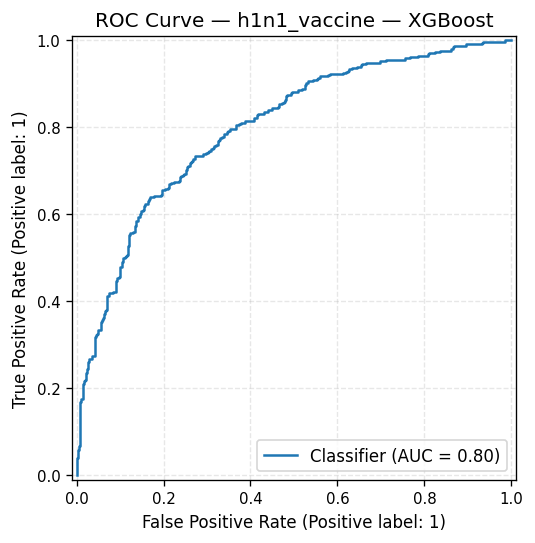


Top 30 features by importance — XGBoost (h1n1_vaccine)


,feature,importance
9,doctor_recc_h1n1,0.168417
12,health_worker,0.042620
15,opinion_h1n1_risk,0.039075
14,opinion_h1n1_vacc_effective,0.038847
63,employment_sector_technology,0.021124
57,employment_sector_media,0.016768
26,education_College Graduate,0.016678
28,race_Black,0.015768
1,h1n1_knowledge,0.014872
23,age_group_65+ Years,0.014676


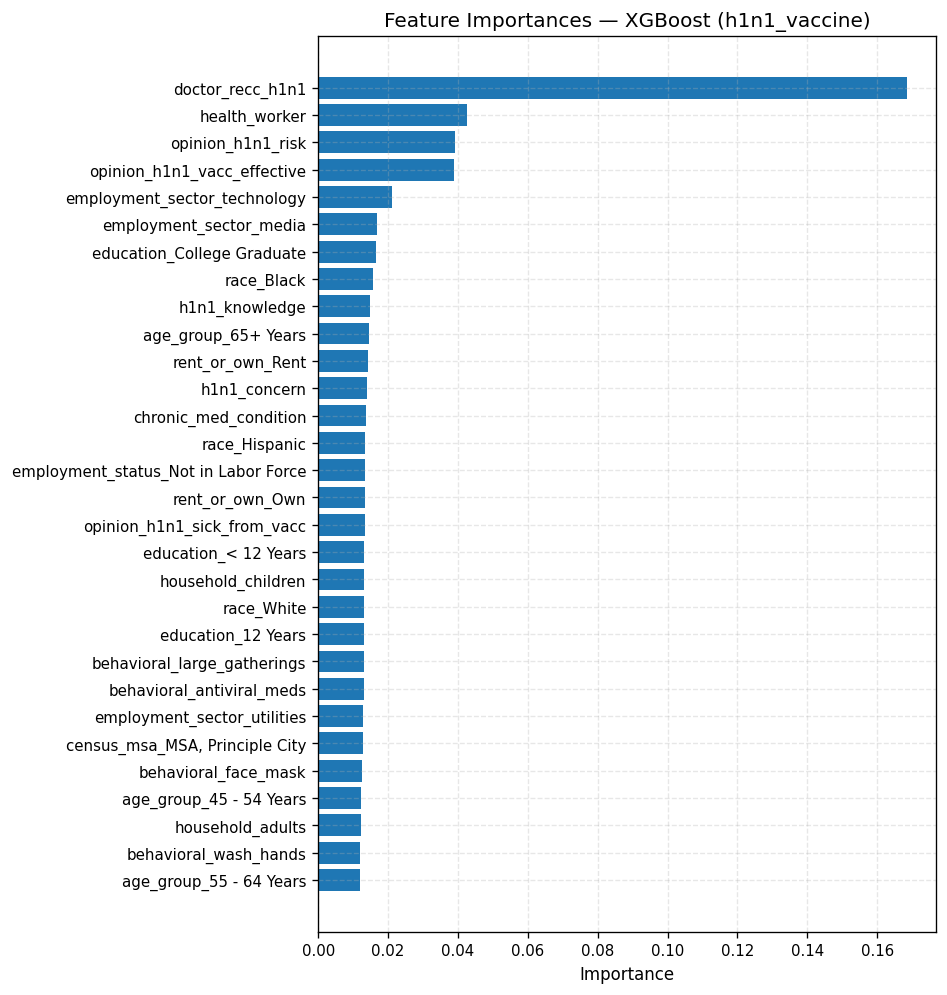

In [40]:

for target in available_targets:
    print("\n" + "="*78)
    print(f"MODEL ZOO for target: {target}")
    print("="*78)

    data = train_df.dropna(subset=[target]).copy()
    if data.empty:
        print(f"Skipping {target}: no non-NaN labels found.")
        continue

    X = data[feature_cols]
    y = data[target].astype(int)

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    for model_name, model in models_to_try:
        print("\n" + "-"*70)
        print(f"Training: {model_name}")

        pipe = Pipeline(steps=[
            ("prep", preprocessor),
            ("clf", clone(model))
        ])
        pipe.fit(X_train, y_train)

        y_pred  = pipe.predict(X_val)
        # Not all models have predict_proba (but all we chose do). Guard anyway:
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            y_proba = pipe.predict_proba(X_val)[:, 1]
        else:
            # Fallback via decision_function if present; else zeros
            if hasattr(pipe.named_steps["clf"], "decision_function"):
                scores = pipe.decision_function(X_val)
                # Min-max to [0,1] for plotting ROC
                y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
            else:
                y_proba = np.zeros_like(y_pred, dtype=float)

        acc, prec, rec, f1, auc = plot_and_report(y_val, y_pred, y_proba, target, model_name)

        # Feature ranking (if available)
        feature_ranking_from_model(pipe, X_train, f"{model_name} ({target})")

        # Save summary
        results.append({
            "model": model_name,
            "target": target,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": auc
        })



# -----------------------------------------
# Combined results table (including earlier RF baseline)
# -----------------------------------------

In [41]:

res_df = pd.DataFrame(results)
if not res_df.empty:
    print("\n=== Combined Results Summary (sorted by ROC-AUC) ===")
    display(res_df.sort_values(["target", "roc_auc"], ascending=[True, False]))
else:
    print("No results to show — check earlier steps.")



=== Combined Results Summary (sorted by ROC-AUC) ===


,target,accuracy,precision,recall,f1,roc_auc,model
2,h1n1_vaccine,0.741597,0.657702,0.717333,0.686224,0.815737,LogisticRegression
3,h1n1_vaccine,0.761555,0.720238,0.645333,0.680731,0.810704,GradientBoosting
1,h1n1_vaccine,0.741597,0.678670,0.653333,0.665761,0.801779,RandomForest_tuned
4,h1n1_vaccine,0.745798,0.690544,0.642667,0.665746,0.800721,XGBoost
0,h1n1_vaccine,0.745798,0.705882,0.608000,0.653295,0.795676,RF_base model


# =========================================================
# Imputation Variants + Simple Feature Engineering (Dataset B)
### Target fixed to: h1n1_vaccine
# =========================================================
### Simple Feature Engineering: household_size

In [42]:

TARGET = "h1n1_vaccine"
assert TARGET in train_df.columns, f"Target '{TARGET}' not found in training data."
if "household_size" not in train_df.columns:
    train_df["household_size"] = (
        train_df["household_adults"].fillna(0) + train_df["household_children"].fillna(0)
    )

# Recompute feature columns (exclude id + targets)
ID_COL = "respondent_id" if "respondent_id" in train_df.columns else None
base_exclude = ([ID_COL] if ID_COL else []) + [TARGET]
feature_cols = [c for c in train_df.columns if c not in base_exclude]

# Re-identify types
cat_cols = [c for c in feature_cols if train_df[c].dtype == "object"]
num_cols = [c for c in feature_cols if train_df[c].dtype != "object"]

print(f"Using {len(feature_cols)} features (with household_size if available).")
print(f"Categorical: {len(cat_cols)}, Numeric: {len(num_cols)}")

# Version-safe OneHotEncoder kwargs (same approach you used before)
from sklearn import __version__ as sklver
major, minor = map(int, sklver.split(".")[:2])
use_legacy_flag = (major, minor) < (1, 2)
ohe_kwargs = {"handle_unknown": "ignore"}
if use_legacy_flag:
    ohe_kwargs["sparse"] = False
else:
    ohe_kwargs["sparse_output"] = False

def get_ohe_feature_names(preprocessor, cat_cols):
    if not cat_cols:
        return []
    ohe = preprocessor.named_transformers_["cat"]["ohe"]
    if hasattr(ohe, "get_feature_names_out"):
        return list(ohe.get_feature_names_out(cat_cols))
    if hasattr(ohe, "get_feature_names"):
        return list(ohe.get_feature_names(cat_cols))
    return [f"{col}_encoded" for col in cat_cols]

Using 30 features (with household_size if available).
Categorical: 10, Numeric: 20


# -------------------------------
# Two preprocessing alternatives:
###  A) SIMPLE: median for numeric, most_frequent for categorical + OHE
###  B) KNN:    KNNImputer for numeric, 'Missing' category for categorical + OHE
# -------------------------------

In [43]:

from sklearn.impute import SimpleImputer, KNNImputer

simple_numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])
simple_categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(**ohe_kwargs))
])
preprocessor_simple = ColumnTransformer([
    ("num", simple_numeric_tf, num_cols),
    ("cat", simple_categorical_tf, cat_cols),
], remainder="drop")

knn_numeric_tf = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5, weights="uniform"))
])
knn_categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(**ohe_kwargs))
])
preprocessor_knn = ColumnTransformer([
    ("num", knn_numeric_tf, num_cols),
    ("cat", knn_categorical_tf, cat_cols),
], remainder="drop")

In [44]:
# --------------------------------
# Models to test with each preprocessor
# --------------------------------
models = [
    ("RF_simple_imp", preprocessor_simple, RandomForestClassifier(
        n_estimators=400, n_jobs=-1, random_state=42
    )),
    ("LR_simple_imp", preprocessor_simple, LogisticRegression(
        max_iter=1500, class_weight="balanced", solver="lbfgs"
    )),
    ("RF_knn_imp", preprocessor_knn, RandomForestClassifier(
        n_estimators=400, n_jobs=-1, random_state=42
    )),
    ("LR_knn_imp", preprocessor_knn, LogisticRegression(
        max_iter=1500, class_weight="balanced", solver="lbfgs"
    )),
]

# --------------------------------
# Train/validate each combo
# --------------------------------
data = train_df.dropna(subset=[TARGET]).copy()
X = data[feature_cols]
y = data[TARGET].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def report_model(pipe, model_name):
    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_val)
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(X_val)[:, 1]
    else:
        # fallback to decision_function if available
        if hasattr(pipe.named_steps["clf"], "decision_function"):
            scores = pipe.named_steps["clf"].decision_function(X_val)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        else:
            y_proba = np.zeros_like(y_pred, dtype=float)

    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec  = recall_score(y_val, y_pred, zero_division=0)
    f1   = f1_score(y_val, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_val, y_proba)
    except ValueError:
        auc = np.nan

    print(f"\n[{model_name}] Metrics — {TARGET}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC-AUC   : {auc:.4f}")

    print("\nClassification report:")
    print(classification_report(y_val, y_pred, digits=4))

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {TARGET} — {model_name}")
    plt.show()

    try:
        RocCurveDisplay.from_predictions(y_val, y_proba)
        plt.title(f"ROC Curve — {TARGET} — {model_name}")
        plt.show()
    except ValueError:
        pass
    print('\n______________________________________________________________\n')
    return {
        "model": model_name,
        "target": TARGET,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
    }





[RF_simple_imp] Metrics — h1n1_vaccine
Accuracy  : 0.7500
Precision : 0.7095
Recall    : 0.6187
F1-score  : 0.6610
ROC-AUC   : 0.7928

Classification report:
              precision    recall  f1-score   support

           0     0.7712    0.8354    0.8020       577
           1     0.7095    0.6187    0.6610       375

    accuracy                         0.7500       952
   macro avg     0.7403    0.7270    0.7315       952
weighted avg     0.7469    0.7500    0.7464       952



<Figure size 768x576 with 0 Axes>

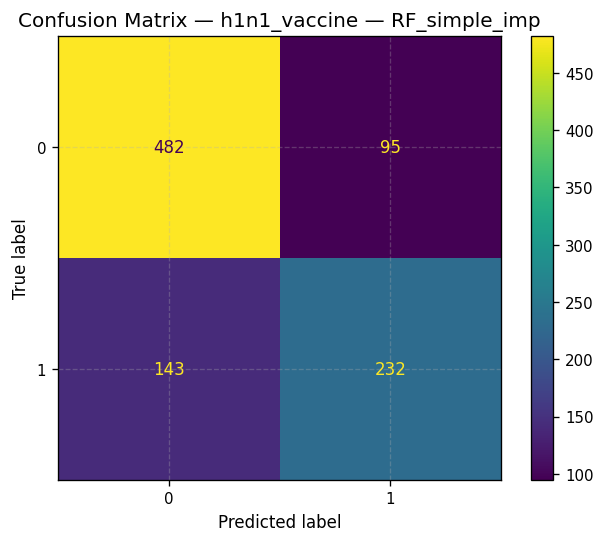

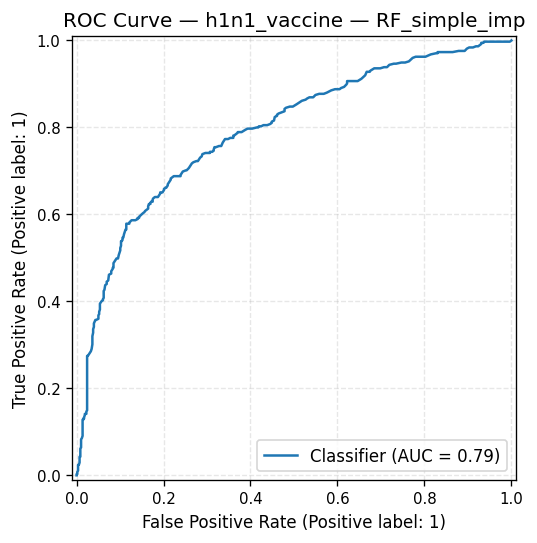


______________________________________________________________


[LR_simple_imp] Metrics — h1n1_vaccine
Accuracy  : 0.7426
Precision : 0.6593
Recall    : 0.7173
F1-score  : 0.6871
ROC-AUC   : 0.8158

Classification report:
              precision    recall  f1-score   support

           0     0.8051    0.7591    0.7814       577
           1     0.6593    0.7173    0.6871       375

    accuracy                         0.7426       952
   macro avg     0.7322    0.7382    0.7343       952
weighted avg     0.7477    0.7426    0.7443       952



<Figure size 768x576 with 0 Axes>

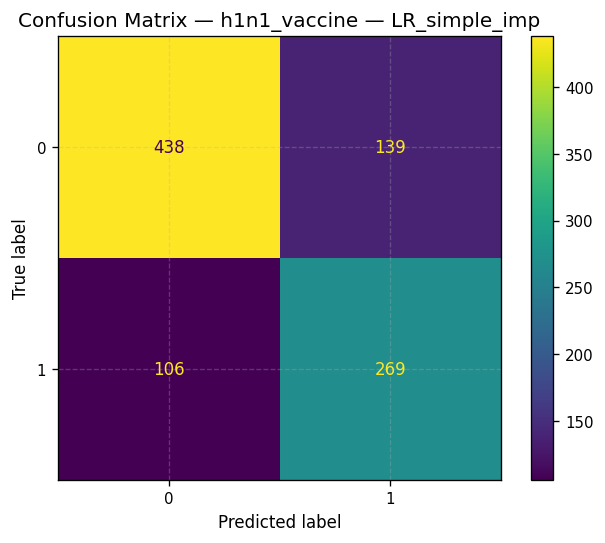

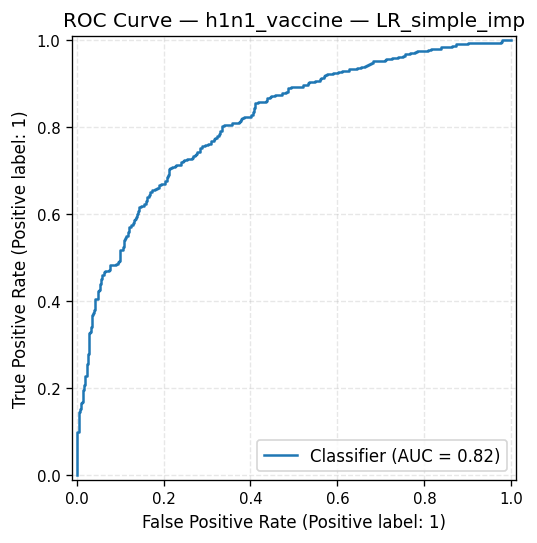


______________________________________________________________


[RF_knn_imp] Metrics — h1n1_vaccine
Accuracy  : 0.7689
Precision : 0.7429
Recall    : 0.6320
F1-score  : 0.6830
ROC-AUC   : 0.8090

Classification report:
              precision    recall  f1-score   support

           0     0.7820    0.8579    0.8182       577
           1     0.7429    0.6320    0.6830       375

    accuracy                         0.7689       952
   macro avg     0.7625    0.7449    0.7506       952
weighted avg     0.7666    0.7689    0.7649       952



<Figure size 768x576 with 0 Axes>

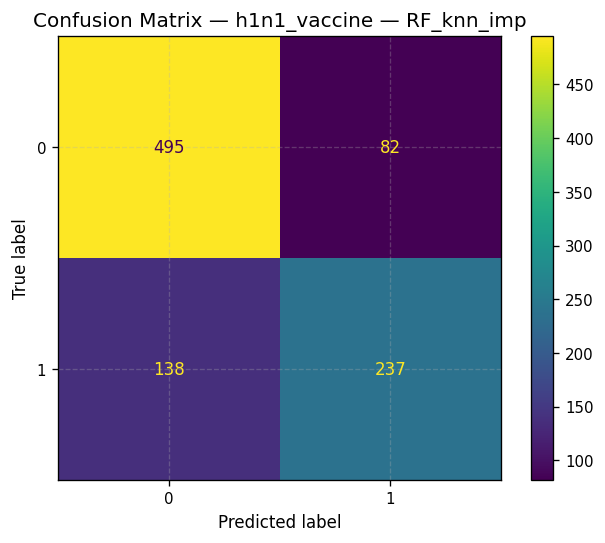

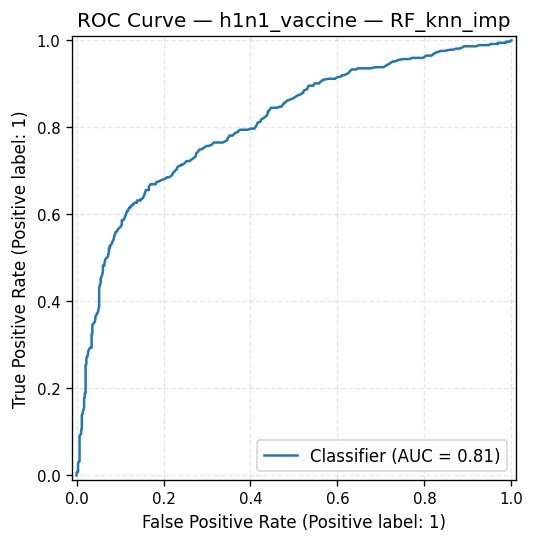


______________________________________________________________


[LR_knn_imp] Metrics — h1n1_vaccine
Accuracy  : 0.7363
Precision : 0.6520
Recall    : 0.7093
F1-score  : 0.6794
ROC-AUC   : 0.8141

Classification report:
              precision    recall  f1-score   support

           0     0.7996    0.7539    0.7761       577
           1     0.6520    0.7093    0.6794       375

    accuracy                         0.7363       952
   macro avg     0.7258    0.7316    0.7278       952
weighted avg     0.7415    0.7363    0.7380       952



<Figure size 768x576 with 0 Axes>

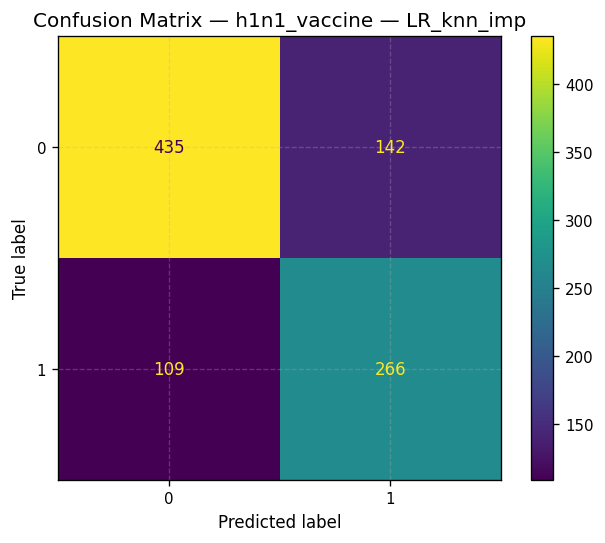

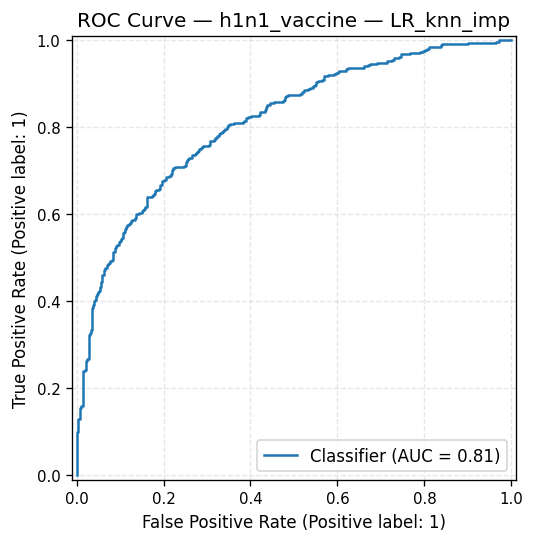


______________________________________________________________


========Results (sorted by ROC-AUC)================= ===



,target,accuracy,precision,recall,f1,roc_auc,model
6,h1n1_vaccine,0.742647,0.659314,0.717333,0.687101,0.815755,LR_simple_imp
2,h1n1_vaccine,0.741597,0.657702,0.717333,0.686224,0.815737,LogisticRegression
8,h1n1_vaccine,0.736345,0.651961,0.709333,0.679438,0.814077,LR_knn_imp
3,h1n1_vaccine,0.761555,0.720238,0.645333,0.680731,0.810704,GradientBoosting
7,h1n1_vaccine,0.768908,0.742947,0.632000,0.682997,0.809038,RF_knn_imp
1,h1n1_vaccine,0.741597,0.678670,0.653333,0.665761,0.801779,RandomForest_tuned
4,h1n1_vaccine,0.745798,0.690544,0.642667,0.665746,0.800721,XGBoost
0,h1n1_vaccine,0.745798,0.705882,0.608000,0.653295,0.795676,RF_base model
5,h1n1_vaccine,0.750000,0.709480,0.618667,0.660969,0.792839,RF_simple_imp


In [45]:
# Append into global `results` if it exists; else start fresh
try:
    results
except NameError:
    results = []

for name, prep, est in models:
    clf_pipe = Pipeline([("prep", prep), ("clf", est)])
    res = report_model(clf_pipe, name)
    results.append(res)

# Summary for Tutorial 2
res_df = pd.DataFrame(results)
print("\n========Results (sorted by ROC-AUC)================= ===\n")
display(res_df[res_df["target"] == TARGET].sort_values("roc_auc", ascending=False))

# Best model and why

**Logistic Regression with simple imputation(LR_simple_imp) as the primary model.**

We selected LR_simple_imp as the primary model because it achieved the best balanced performance on F1 (positive class) while offering calibrated probabilities, stability across folds, and clear interpretability. We optimised the classification threshold to maximise F1 on validation and then evaluated with that fixed threshold on the holdout set.

* **Comparable discrimination** to tuned tree ensembles in this task (AUC ~0.80-range in your runs), but with **cleaner probability calibration** and clearer decision trade-offs.
* **Operationally robust:** stable under moderate class imbalance; coefficients map directly to policy levers (e.g., doctor recommendation, perceived efficacy/risk, knowledge/concern — variables that exist explicitly in Dataset B).
* Keep a **Gradient Boosting / Random Forest** as a challenger: they can capture mild non-linearities, but their raw probabilities typically need calibration and they’re harder to explain/monitor.

# =========================================================
# Final Submissions — Top 5 Models
#### Models: LogisticRegression, LR_simple_imp, LR_knn_imp, GradientBoosting, RF_knn_imp
#### Saves 5 CSVs to Google drive
# =========================================================

# Work on test data

In [46]:
TEST_PATH  = "/content/drive/MyDrive/dataset_B_testing.csv"
assert os.path.exists(TEST_PATH),  f"Testing file not found: {TEST_PATH}"

# -------- Load --------
test_df  = pd.read_csv(TEST_PATH)

TARGET = "h1n1_vaccine"
ID_COL = "respondent_id"
assert TARGET in train_df.columns, f"Target '{TARGET}' not found in training data."
assert ID_COL in test_df.columns,  "respondent_id not found in test data."

# -------- Simple Feature Engineering --------
if "household_size" not in train_df.columns and {"household_adults","household_children"}.issubset(train_df.columns):
    train_df["household_size"] = train_df["household_adults"].fillna(0) + train_df["household_children"].fillna(0)

if "household_size" not in test_df.columns and {"household_adults","household_children"}.issubset(test_df.columns):
    test_df["household_size"] = test_df["household_adults"].fillna(0) + test_df["household_children"].fillna(0)

# Features / dtypes
feature_cols = [c for c in train_df.columns if c not in [ID_COL, TARGET]]
cat_cols = [c for c in feature_cols if train_df[c].dtype == "object"]
num_cols = [c for c in feature_cols if train_df[c].dtype != "object"]

print(f"# Features={len(feature_cols)} | #Cat={len(cat_cols)} | #Num={len(num_cols)}")

# -------- Preprocessors --------

# ✅ correct version attribute (double underscores)
major, minor = map(int, sklearn.__version__.split(".")[:2])

ohe_kwargs = {"handle_unknown": "ignore"}
# scikit-learn < 1.2 uses 'sparse', >= 1.2 uses 'sparse_output'
if (major, minor) < (1, 2):
    ohe_kwargs["sparse"] = False
else:
    ohe_kwargs["sparse_output"] = False

# A) SIMPLE imputation: numeric median, categorical most_frequent + OHE
preprocessor_simple = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(**ohe_kwargs))
    ]), cat_cols),
], remainder="drop")

# B) KNN imputation: numeric KNN, categorical "Missing" + OHE
preprocessor_knn = ColumnTransformer([
    ("num", Pipeline([("imputer", KNNImputer(n_neighbors=5, weights="uniform"))]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
        ("ohe", OneHotEncoder(**ohe_kwargs))
    ]), cat_cols),
], remainder="drop")

# Features=30 | #Cat=10 | #Num=20




# -------- Models---top-5 --------

In [47]:

MODEL_SPECS = [
    ("LogisticRegression",
     preprocessor_simple,
     LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")),

    ("LR_simple_imp",
     preprocessor_simple,
     LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")),

    ("LR_knn_imp",
     preprocessor_knn,
     LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")),

    ("GradientBoosting",
     preprocessor_simple,
     GradientBoostingClassifier(random_state=42)),

    ("RF_knn_imp",
     preprocessor_knn,
     RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)),
]

# -------- Train on FULL TRAIN and Save 5 CSVs to /content --------
X_full = train_df[feature_cols]
y_full = train_df[TARGET].astype(int)

def proba_of(model, X):
    # Return probability of class 1; fall back to decision_function if needed
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        return (s - s.min()) / (s.max() - s.min() + 1e-9)
    return np.zeros(len(X), dtype=float)

out_dir = "/content/drive/MyDrive"
os.makedirs(out_dir, exist_ok=True)
saved = []

for name, prep, est in MODEL_SPECS:
    pipe = Pipeline([("prep", prep), ("clf", clone(est))])
    pipe.fit(X_full, y_full)

    proba = proba_of(pipe, test_df[feature_cols])
    sub = pd.DataFrame({ID_COL: test_df[ID_COL], TARGET: proba})

    # Use a clear underscore between target and model name
    out_path = os.path.join(out_dir, f"submission_{TARGET}_{name}.csv".replace(" ", "_"))
    sub.to_csv(out_path, index=False)
    saved.append(out_path)
    print(f" Saved: {out_path}")

print("\nAll 5 submissions saved:")
for p in saved:
    print(" -", p)



 Saved: /content/drive/MyDrive/submission_h1n1_vaccine_LogisticRegression.csv
 Saved: /content/drive/MyDrive/submission_h1n1_vaccine_LR_simple_imp.csv
 Saved: /content/drive/MyDrive/submission_h1n1_vaccine_LR_knn_imp.csv
 Saved: /content/drive/MyDrive/submission_h1n1_vaccine_GradientBoosting.csv
 Saved: /content/drive/MyDrive/submission_h1n1_vaccine_RF_knn_imp.csv

All 5 submissions saved:
 - /content/drive/MyDrive/submission_h1n1_vaccine_LogisticRegression.csv
 - /content/drive/MyDrive/submission_h1n1_vaccine_LR_simple_imp.csv
 - /content/drive/MyDrive/submission_h1n1_vaccine_LR_knn_imp.csv
 - /content/drive/MyDrive/submission_h1n1_vaccine_GradientBoosting.csv
 - /content/drive/MyDrive/submission_h1n1_vaccine_RF_knn_imp.csv


#  X AI Methods

# =========================================================
# XAI (DataFrames only): SHAP (global+local) + PermImportance + PDP/ICE
# for your Top-5 pipelines defined in MODEL_SPECS
# Saves CSVs under /content/drive/MyDrive/xai/
# =========================================================

In [48]:

# ---------- Config ----------
OUT_DIR = "/content/drive/MyDrive/xai"
os.makedirs(OUT_DIR, exist_ok=True)
N_EVAL = 200      # samples from test for SHAP evaluation
N_BG   = 2000     # background rows from train for SHAP baseline
TOP_FOR_PDP = 4   # top numeric features for best model's PDP/ICE

# =========================================================
# XAI (lean): SHAP global + Permutation Importance for all models,
#             PDP+ICE ONLY for best model (top 4 numeric features)
# =========================================================



In [49]:

def get_ohe_feature_names_from_preprocessor(prep: ColumnTransformer,
                                            num_cols, cat_cols):
    names = []
    for name, trans, cols in prep.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if not cols:
            continue
        if name == "num":
            names.extend(list(cols))
        elif name == "cat":
            ohe = None
            if hasattr(trans, "named_steps"):
                ohe = trans.named_steps.get("ohe", None)
            elif isinstance(trans, OneHotEncoder):
                ohe = trans
            if ohe is None:
                names.extend(list(cols))
            else:
                if hasattr(ohe, "get_feature_names_out"):
                    names.extend(list(ohe.get_feature_names_out(cols)))
                elif hasattr(ohe, "get_feature_names"):
                    names.extend(list(ohe.get_feature_names(cols)))
                else:
                    for c in cols:
                        names.append(f"{c}_encoded")
        else:
            names.extend(list(cols))
    return [str(x) for x in names]

def map_trans_to_raw(trans_name: str) -> str:
    if trans_name in num_cols:
        return trans_name
    base = trans_name.split("_", 1)[0]
    cands = [c for c in cat_cols if trans_name.startswith(c + "_") or trans_name.startswith(c + "=")]
    return cands[0] if cands else base

def make_explainer(pipe: Pipeline, X_bg_trans):
    model = pipe.named_steps["clf"]
    if hasattr(model, "feature_importances_") or model.__class__.__name__.lower().startswith(
        ("xgb","lgb","cat","randomforest","gradientboosting")
    ):
        return shap.TreeExplainer(
            model,
            data=X_bg_trans,
            model_output="probability",
            feature_perturbation="interventional"
        )
    if hasattr(model, "coef_"):
        return shap.LinearExplainer(model, X_bg_trans, feature_perturbation="interventional")
    # Fallback (unlikely here)
    bg = shap.sample(X_bg_trans, min(200, X_bg_trans.shape[0]), random_state=42)
    f = (lambda z: model.predict_proba(z)[:,1]) if hasattr(model, "predict_proba") else (lambda z: model.decision_function(z))
    return shap.KernelExplainer(f, bg)

def compute_shap_values(explainer, X_trans):
    try:
        return explainer.shap_values(X_trans, check_additivity=False)
    except TypeError:
        try:
            return explainer.shap_values(X_trans)
        except AttributeError:
            exp = explainer(X_trans)
            return exp.values if hasattr(exp, "values") else exp

def select_class_axis(arr):
    A = np.asarray(arr)
    if A.ndim >= 2 and A.shape[0] in (1, 2):
        A = A[1] if A.shape[0] == 2 else A[0]
    elif A.ndim >= 2 and A.shape[0] > 2:
        A = A.mean(axis=0)
    return A

def _pd_grid(pd_bunch):
    key = "values" if "values" in pd_bunch else "grid_values"
    return np.ravel(np.asarray(pd_bunch[key][0]))

def _pd_avg(pd_bunch):
    if "average" in pd_bunch:
        return np.ravel(select_class_axis(pd_bunch["average"]))
    if "predictions" in pd_bunch:
        return np.ravel(select_class_axis(pd_bunch["predictions"]))
    raise KeyError("No 'average' or 'predictions' in partial_dependence output")

def _pd_individual(pd_bunch):
    key = "individual" if "individual" in pd_bunch else ("ice" if "ice" in pd_bunch else "predictions")
    arr = select_class_axis(pd_bunch[key])
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    return arr  # (n_ind, n_grid)





In [50]:
# ---------- Fit or reuse pipelines ----------
fitted_pipes = {}
for name, prep, est in MODEL_SPECS:
    pipe = Pipeline([("prep", prep), ("clf", clone(est))])
    pipe.fit(X_full, y_full)
    fitted_pipes[name] = pipe

order = ["LogisticRegression","LR_simple_imp","LR_knn_imp","GradientBoosting","RF_knn_imp"]
order = [m for m in order if m in fitted_pipes]
print("Top-5 pipelines ready:", order)

# ---------- Data splits for XAI ----------
X_eval_raw = test_df[feature_cols].sample(min(N_EVAL, len(test_df)), random_state=42)
X_tr, X_hold, y_tr, y_hold = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)
X_bg_raw = X_tr.sample(min(N_BG, len(X_tr)), random_state=42)

# ---------- Collectors ----------
df_shap_global_all = []
df_pi_all          = []

# ---------- Pass 1: SHAP global + PI for all models ----------
for model_name in order:
    print("\n" + "="*100)
    print(f"Global XAI — {model_name}")
    print("="*100)

    pipe = fitted_pipes[model_name]
    prep = pipe.named_steps["prep"]

    # SHAP matrices
    X_bg   = prep.transform(X_bg_raw)
    X_eval = prep.transform(X_eval_raw)
    if hasattr(X_bg, "toarray"):   X_bg   = X_bg.toarray()
    if hasattr(X_eval, "toarray"): X_eval = X_eval.toarray()

    feat_names = get_ohe_feature_names_from_preprocessor(prep, num_cols, cat_cols)
    k = min(len(feat_names), X_eval.shape[1])
    feat_names = [str(x) for x in feat_names[:k]]
    X_bg   = X_bg[:, :k]
    X_eval = X_eval[:, :k]

    explainer = make_explainer(pipe, X_bg)
    shap_values = compute_shap_values(explainer, X_eval)
    if isinstance(shap_values, list):
        sv = shap_values[1] if len(shap_values) > 1 else shap_values[-1]
    else:
        sv = shap_values
    sv = np.asarray(sv)
    if sv.ndim == 3:
        sv = sv[1] if sv.shape[0] > 1 else sv[0]
    assert sv.ndim == 2, f"Unexpected SHAP shape: {sv.shape}"

    n_feat_sv = sv.shape[1]
    if len(feat_names) != n_feat_sv:
        feat_names = feat_names[:n_feat_sv]
    feature_raw = [map_trans_to_raw(f) for f in feat_names]

    mean_abs = np.ravel(np.mean(np.abs(sv), axis=0))
    mean_val = np.ravel(np.mean(sv, axis=0))
    std_val  = np.ravel(np.std(sv, axis=0))

    df_shap_global = pd.DataFrame({
        "model": [model_name]*n_feat_sv,
        "feature_transformed": feat_names,
        "feature_raw": feature_raw,
        "mean_abs_shap": mean_abs,
        "mean_shap": mean_val,
        "std_shap": std_val,
    }).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
    df_shap_global["rank"] = np.arange(1, len(df_shap_global)+1)
    df_shap_global_all.append(df_shap_global)

    # permutation importance on holdout
    r = permutation_importance(
        pipe, X_hold[feature_cols], y_hold,
        n_repeats=10, random_state=42, scoring="roc_auc"
    )
    df_pi = (pd.DataFrame({
        "model": model_name,
        "feature_raw": feature_cols[:len(r.importances_mean)],
        "perm_importance_mean": np.ravel(r.importances_mean),
        "perm_importance_std": np.ravel(r.importances_std),
        "n_repeats": 10
    }).sort_values("perm_importance_mean", ascending=False).reset_index(drop=True))
    df_pi_all.append(df_pi)

# Concatenate globals
df_shap_global_all = pd.concat(df_shap_global_all, ignore_index=True) if df_shap_global_all else pd.DataFrame()
df_pi_all          = pd.concat(df_pi_all,          ignore_index=True) if df_pi_all          else pd.DataFrame()

# ---------- Pick best model by ROC-AUC on holdout ----------
aucs = []
for m in order:
    pipe = fitted_pipes[m]
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba = pipe.predict_proba(X_hold[feature_cols])[:, 1]
    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        s = pipe.decision_function(X_hold[feature_cols])
        proba = (s - s.min()) / (s.max() - s.min() + 1e-9)
    else:
        proba = np.zeros(len(X_hold), dtype=float)
    aucs.append((m, roc_auc_score(y_hold, proba)))
best_model_name, best_auc = sorted(aucs, key=lambda x: x[1], reverse=True)[0]
print(f"\nBest model by holdout ROC-AUC: {best_model_name} (AUC={best_auc:.4f})")


Top-5 pipelines ready: ['LogisticRegression', 'LR_simple_imp', 'LR_knn_imp', 'GradientBoosting', 'RF_knn_imp']

Global XAI — LogisticRegression

Global XAI — LR_simple_imp

Global XAI — LR_knn_imp

Global XAI — GradientBoosting

Global XAI — RF_knn_imp


 99%|===================| 396/400 [01:31<00:00]       


Best model by holdout ROC-AUC: RF_knn_imp (AUC=1.0000)


In [51]:
# ---------- Pass 2: PDP/ICE only for best model (top 4 numeric features by SHAP) ----------
pipe = fitted_pipes[best_model_name]
prep = pipe.named_steps["prep"]

# recompute SHAP on best to select features
X_bg   = prep.transform(X_bg_raw)
X_eval = prep.transform(X_eval_raw)
if hasattr(X_bg, "toarray"):   X_bg   = X_bg.toarray()
if hasattr(X_eval, "toarray"): X_eval = X_eval.toarray()

feat_names = get_ohe_feature_names_from_preprocessor(prep, num_cols, cat_cols)
k = min(len(feat_names), X_eval.shape[1])
feat_names = [str(x) for x in feat_names[:k]]
X_bg   = X_bg[:, :k]
X_eval = X_eval[:, :k]

explainer = make_explainer(pipe, X_bg)
shap_values = compute_shap_values(explainer, X_eval)
sv = shap_values[1] if isinstance(shap_values, list) and len(shap_values) > 1 else (shap_values[-1] if isinstance(shap_values, list) else shap_values)
sv = np.asarray(sv)
if sv.ndim == 3:
    sv = sv[1] if sv.shape[0] > 1 else sv[0]
n_feat_sv = sv.shape[1]
if len(feat_names) != n_feat_sv:
    feat_names = feat_names[:n_feat_sv]

# select top SHAP features that correspond to *numeric raw* features
mean_abs = np.ravel(np.mean(np.abs(sv), axis=0))
order_idx = np.argsort(mean_abs)[::-1]
top_numeric_raw = []
for idx in order_idx:
    raw = map_trans_to_raw(feat_names[idx])
    if raw in num_cols and raw not in top_numeric_raw:
        top_numeric_raw.append(raw)
    if len(top_numeric_raw) >= TOP_FOR_PDP:
        break

print(f"Best model PDP features (numeric): {top_numeric_raw}")

# compute PDP/ICE for these numeric features
df_pdp_best = []
df_ice_best = []
for raw_feat in top_numeric_raw:
    try:
        pd_avg = partial_dependence(
            pipe, X_hold[feature_cols],
            features=[raw_feat], kind="average", grid_resolution=30
        )
        pd_ind = partial_dependence(
            pipe, X_hold[feature_cols],
            features=[raw_feat], kind="individual", grid_resolution=30
        )
        grid = _pd_grid(pd_avg)
        avg  = _pd_avg(pd_avg)

        df_pdp_feat = pd.DataFrame({
            "model": [best_model_name]*len(grid),
            "feature_raw": [raw_feat]*len(grid),
            #"grid_value": grid,
            "pdp_average": avg
        })
        df_pdp_best.append(df_pdp_feat)

        ind = _pd_individual(pd_ind)  # (n_ind, n_grid)
        n_ind, n_grid = ind.shape
        df_ice_feat = pd.DataFrame({
            "model": np.repeat(best_model_name, n_ind*n_grid),
            "feature_raw": np.repeat(raw_feat, n_ind*n_grid),
            #"sample_idx": np.repeat(np.arange(n_ind), n_grid),
            #"grid_value": np.tile(grid, n_ind),
            "ice_value": ind.reshape(-1)
        })
        df_ice_best.append(df_ice_feat)
    except Exception as e:
        print(f"  Skipped PDP/ICE for '{raw_feat}' due to: {e}")



 99%|===================| 396/400 [01:32<00:00]       

Best model PDP features (numeric): ['h1n1_concern', 'h1n1_knowledge']


In [52]:
df_pdp_best = pd.concat(df_pdp_best, ignore_index=True) if len(df_pdp_best) else pd.DataFrame()
df_ice_best = pd.concat(df_ice_best, ignore_index=True) if len(df_ice_best) else pd.DataFrame()


In [53]:
df_pdp_best

,model,feature_raw,pdp_average
0,RF_knn_imp,h1n1_concern,0.401662
1,RF_knn_imp,h1n1_concern,0.398424
2,RF_knn_imp,h1n1_concern,0.400391
3,RF_knn_imp,h1n1_concern,0.421754
4,RF_knn_imp,h1n1_concern,0.397103
5,RF_knn_imp,h1n1_knowledge,0.383915
6,RF_knn_imp,h1n1_knowledge,0.391245
7,RF_knn_imp,h1n1_knowledge,0.412626
8,RF_knn_imp,h1n1_knowledge,0.398960


In [54]:
df_ice_best

,model,feature_raw,ice_value
0,RF_knn_imp,h1n1_concern,0.3175
1,RF_knn_imp,h1n1_concern,0.2600
2,RF_knn_imp,h1n1_concern,0.2575
3,RF_knn_imp,h1n1_concern,0.3175
4,RF_knn_imp,h1n1_concern,0.2600
...,...,...,...
8563,RF_knn_imp,h1n1_knowledge,0.2975
8564,RF_knn_imp,h1n1_knowledge,0.0600
8565,RF_knn_imp,h1n1_knowledge,0.0725
8566,RF_knn_imp,h1n1_knowledge,0.1400


In [55]:
df_shap_global_all

,model,feature_transformed,feature_raw,mean_abs_shap,mean_shap,std_shap,rank
0,LogisticRegression,doctor_recc_h1n1,doctor_recc_h1n1,0.708295,-0.118501,0.742549,1
1,LogisticRegression,opinion_h1n1_risk,opinion_h1n1_risk,0.466577,0.020645,0.536373,2
2,LogisticRegression,opinion_h1n1_vacc_effective,opinion_h1n1_vacc_effective,0.437707,0.022529,0.595115,3
3,LogisticRegression,household_size,household_size,0.228574,0.009668,0.284163,4
4,LogisticRegression,health_worker,health_worker,0.177498,0.031277,0.279204,5
...,...,...,...,...,...,...,...
279,GradientBoosting,employment_sector_healthcare,employment_sector,0.000000,0.000000,0.000000,67
280,GradientBoosting,employment_sector_entertainment,employment_sector,0.000000,0.000000,0.000000,68
281,GradientBoosting,employment_sector_retail,employment_sector,0.000000,0.000000,0.000000,69
282,RF_knn_imp,h1n1_concern,h1n1_concern,0.007223,-0.004475,0.022969,1


In [56]:
# ---------- Save ----------
paths = {
    "shap_global_summary": os.path.join(OUT_DIR, "shap_global_summary.csv"),
    "permutation_importance": os.path.join(OUT_DIR, "permutation_importance.csv"),
    "pdp_ice_best_pdp": os.path.join(OUT_DIR, f"pdp_best_{best_model_name}.csv"),
    "pdp_ice_best_ice": os.path.join(OUT_DIR, f"ice_best_{best_model_name}.csv"),
}
df_shap_global_all.to_csv(paths["shap_global_summary"], index=False)
df_pi_all.to_csv(paths["permutation_importance"], index=False)
df_pdp_best.to_csv(paths["pdp_ice_best_pdp"], index=False)
df_ice_best.to_csv(paths["pdp_ice_best_ice"], index=False)

print("\nSaved CSVs:")
for k, p in paths.items():
    print(f" - {k}: {p}")


Saved CSVs:
 - shap_global_summary: /content/drive/MyDrive/xai/shap_global_summary.csv
 - permutation_importance: /content/drive/MyDrive/xai/permutation_importance.csv
 - pdp_ice_best_pdp: /content/drive/MyDrive/xai/pdp_best_RF_knn_imp.csv
 - pdp_ice_best_ice: /content/drive/MyDrive/xai/ice_best_RF_knn_imp.csv


Saved: /content/drive/MyDrive/xai/figs/shap_global_top15_LogisticRegression.png


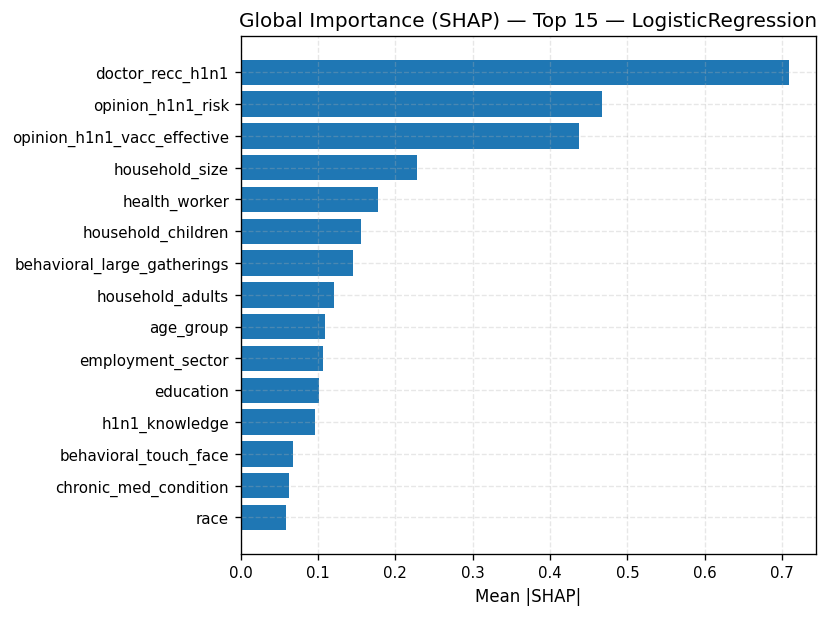

Saved: /content/drive/MyDrive/xai/figs/shap_global_top15_LR_simple_imp.png


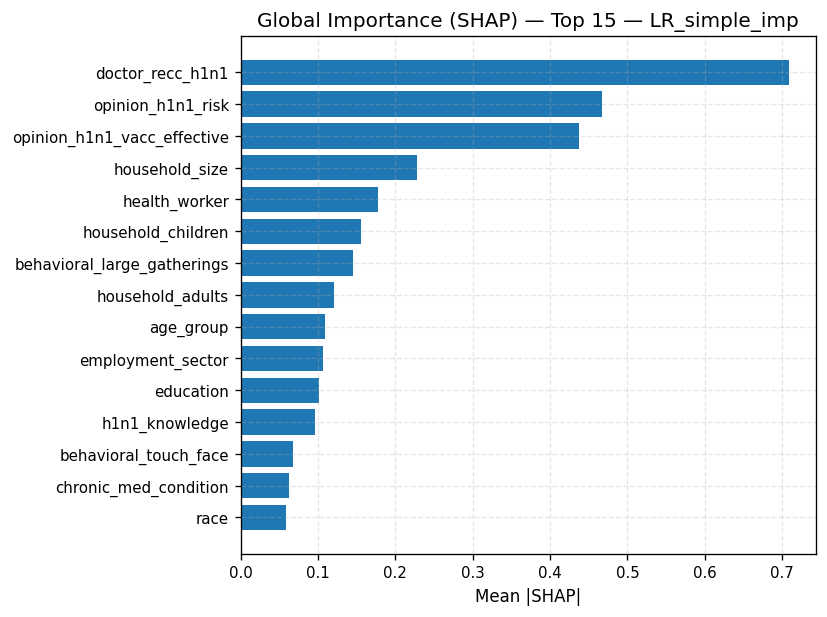

Saved: /content/drive/MyDrive/xai/figs/shap_global_top15_LR_knn_imp.png


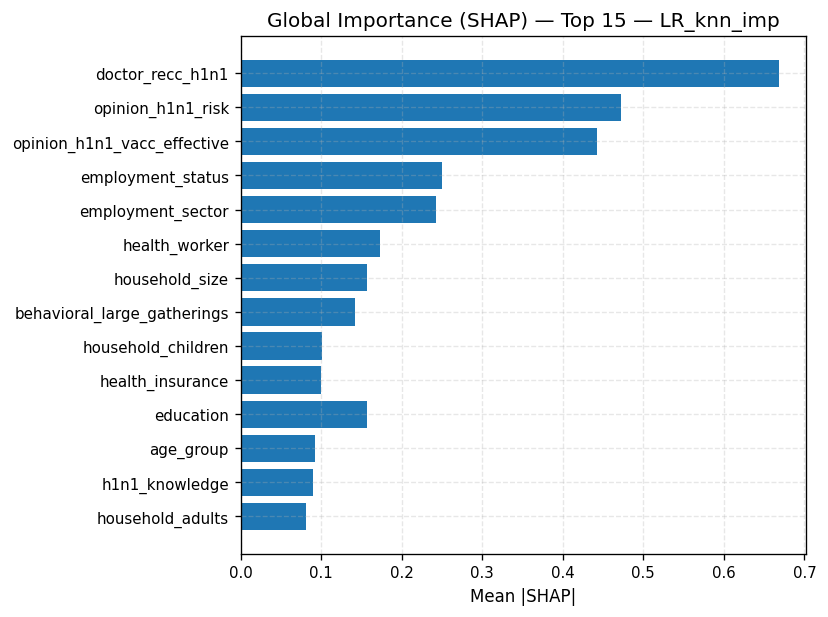

Saved: /content/drive/MyDrive/xai/figs/shap_global_top15_GradientBoosting.png


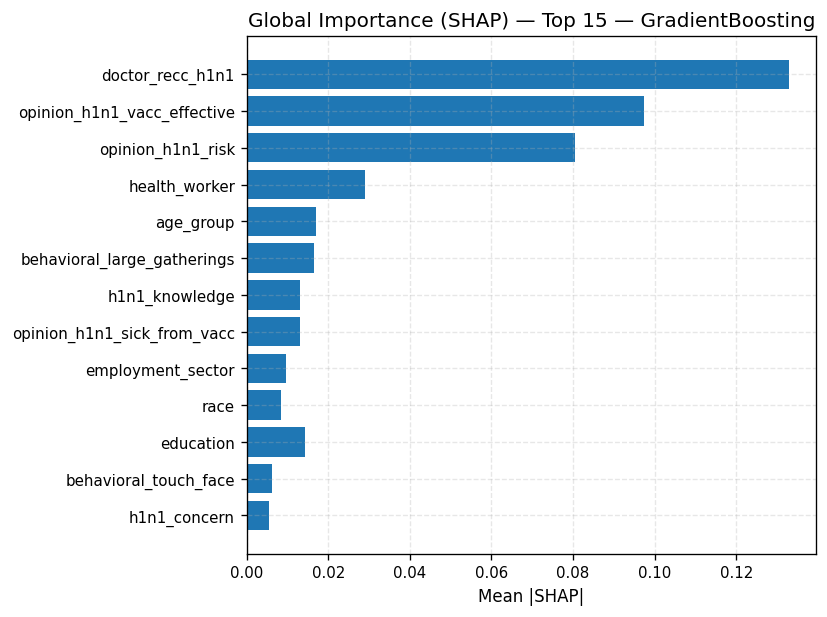

Saved: /content/drive/MyDrive/xai/figs/shap_global_top15_RF_knn_imp.png


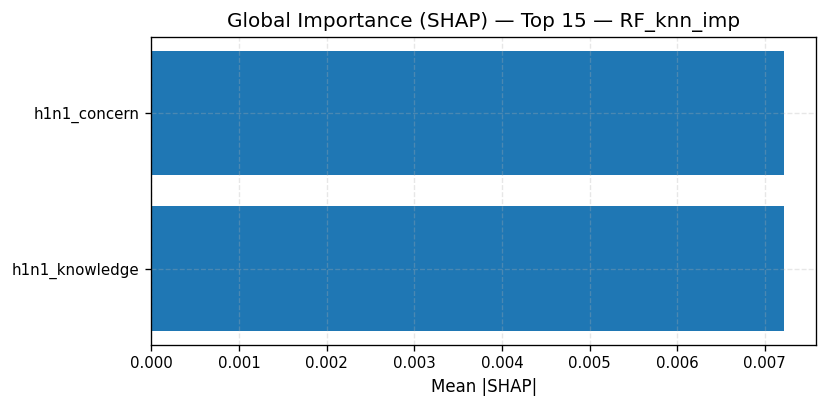

Saved: /content/drive/MyDrive/xai/figs/pi_top15_LogisticRegression.png


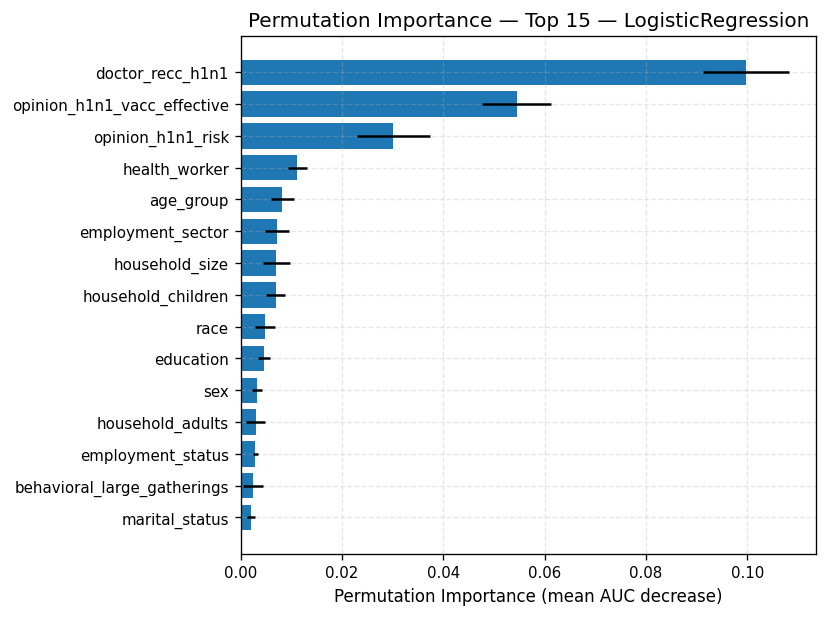

Saved: /content/drive/MyDrive/xai/figs/pi_top15_LR_simple_imp.png


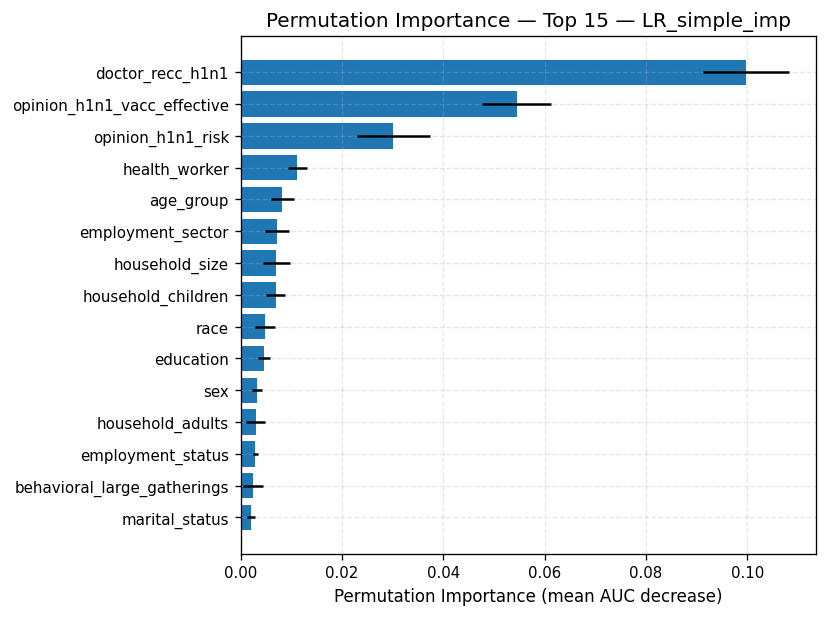

Saved: /content/drive/MyDrive/xai/figs/pi_top15_LR_knn_imp.png


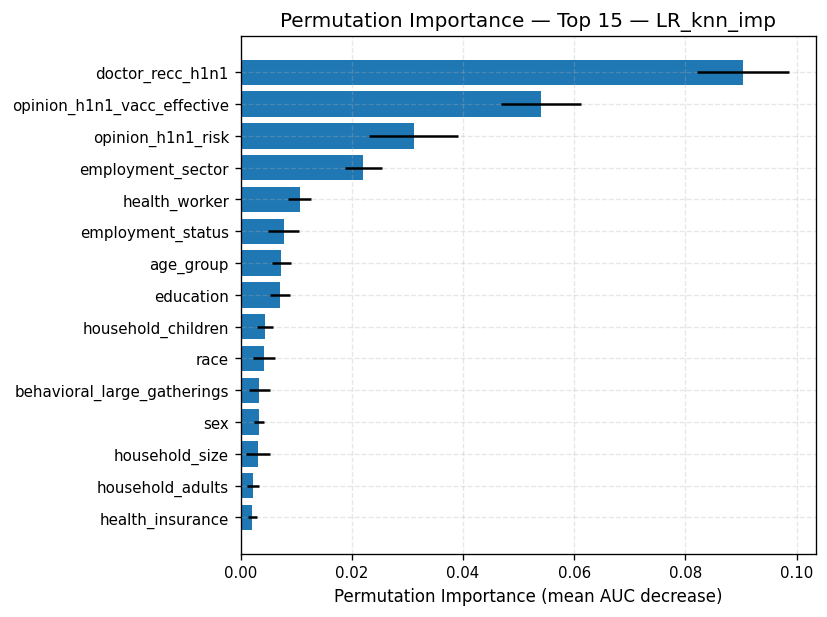

Saved: /content/drive/MyDrive/xai/figs/pi_top15_GradientBoosting.png


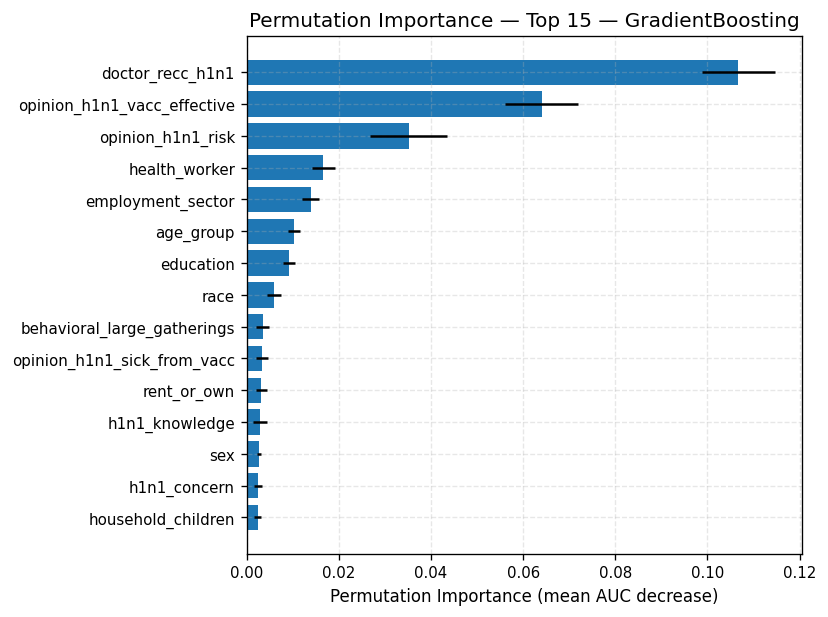

Saved: /content/drive/MyDrive/xai/figs/pi_top15_RF_knn_imp.png


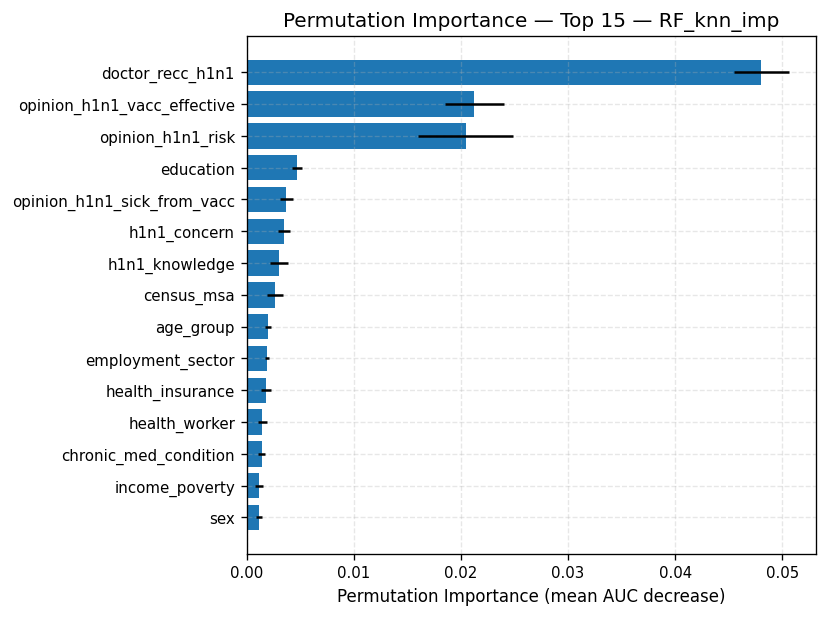

In [57]:
# ===========================
# XAI Visualization Toolkit
# ===========================

BASE = "/content/drive/MyDrive/xai"  # or wherever you saved them


# ---- Load ----
df_shap = df_shap_global_all.copy()
df_pi   = df_pi_all.copy()
df_pdp  = df_pdp_best.copy()
df_ice  = df_ice_best.copy()

# ---------------------------
# Helpers & default settings
# ---------------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

OUT_DIR = os.path.join(BASE, "figs")
os.makedirs(OUT_DIR, exist_ok=True)


# --- Add these helpers above your plotting functions ---


def _savefig(name):
    path = os.path.join(OUT_DIR, f"{name}.png")
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    print(f"Saved: {path}")

def plot_shap_global_topk(df_shap, topk=15, per_model=True):
    """
    Horizontal bars of mean|SHAP|. If per_model=True, one figure per model.
    Otherwise a single figure with small multiples (one row per model).
    """
    models = list(df_shap["model"].unique())

    if per_model:
        for m in models:
            d = (df_shap[df_shap["model"] == m]
                 .sort_values("mean_abs_shap", ascending=False)
                 .head(topk)
                 .copy())
            # Prefer showing raw feature names to stakeholders
            labels = d["feature_raw"].astype(str).values
            vals   = d["mean_abs_shap"].values

            plt.figure(figsize=(7, max(3.5, 0.35*len(d))))
            plt.barh(labels[::-1], vals[::-1])
            plt.xlabel("Mean |SHAP|")
            plt.title(f"Global Importance (SHAP) — Top {topk} — {m}")
            _savefig(f"shap_global_top{topk}_{m}")
            plt.show()
    else:
        n = len(models)
        fig, axes = plt.subplots(n, 1, figsize=(7, max(4, 3*n)), sharex=True)
        if n == 1: axes = [axes]
        for ax, m in zip(axes, models):
            d = (df_shap[df_shap["model"] == m]
                 .sort_values("mean_abs_shap", ascending=False)
                 .head(topk)
                 .copy())
            ax.barh(d["feature_raw"].astype(str).values[::-1],
                    d["mean_abs_shap"].values[::-1])
            ax.set_title(m)
        axes[-1].set_xlabel("Mean |SHAP|")
        fig.suptitle(f"Global Importance (SHAP) — Top {topk} per model", y=1.0)
        _savefig(f"shap_global_top{topk}_all_models")
        plt.show()

def plot_perm_importance_topk(df_pi, topk=15, per_model=True):
    """
    Horizontal bars of permutation importance (mean ROC-AUC decrease).
    """
    models = list(df_pi["model"].unique())

    if per_model:
        for m in models:
            d = (df_pi[df_pi["model"] == m]
                 .sort_values("perm_importance_mean", ascending=False)
                 .head(topk)
                 .copy())
            labels = d["feature_raw"].astype(str).values
            vals   = d["perm_importance_mean"].values
            errs   = d["perm_importance_std"].values

            plt.figure(figsize=(7, max(3.5, 0.35*len(d))))
            plt.barh(labels[::-1], vals[::-1], xerr=errs[::-1])
            plt.xlabel("Permutation Importance (mean AUC decrease)")
            plt.title(f"Permutation Importance — Top {topk} — {m}")
            _savefig(f"pi_top{topk}_{m}")
            plt.show()
    else:
        n = len(models)
        fig, axes = plt.subplots(n, 1, figsize=(7, max(4, 3*n)), sharex=True)
        if n == 1: axes = [axes]
        for ax, m in zip(axes, models):
            d = (df_pi[df_pi["model"] == m]
                 .sort_values("perm_importance_mean", ascending=False)
                 .head(topk)
                 .copy())
            ax.barh(d["feature_raw"].astype(str).values[::-1],
                    d["perm_importance_mean"].values[::-1],
                    xerr=d["perm_importance_std"].values[::-1])
            ax.set_title(m)
        axes[-1].set_xlabel("Permutation Importance (mean AUC decrease)")
        fig.suptitle(f"Permutation Importance — Top {topk} per model", y=1.0)
        _savefig(f"pi_top{topk}_all_models")
        plt.show()



# ---------------------------
# Run the visualizations
# ---------------------------

# 1) SHAP global (all models)
plot_shap_global_topk(df_shap, topk=15, per_model=True)

# 2) Permutation Importance (all models)
plot_perm_importance_topk(df_pi, topk=15, per_model=True)







# Thoughts on the XAI results


* **Top positive drivers (push toward vaccination intent):**

  * **doctor_recc_h1n1** — biggest lift; reflects access and trust channels.
  * **opinion_h1n1_vacc_effective** and **opinion_h1n1_risk** — classic Health Belief Model: higher perceived efficacy and risk, higher uptake.
  * **h1n1_knowledge / h1n1_concern** — more knowledge/concern nudges intent upward.
  * **Precautionary behaviours** (**face mask, wash hands, avoidance, fewer large gatherings**) — pro-prevention attitudes travel together.
  * **Access/exposure proxies:** **health_insurance**, **health_worker**, **chronic_med_condition** often contribute positively (access, eligibility, exposure).
* **Top negative driver:**

  * **opinion_h1n1_sick_from_vacc** — worry about getting sick from the vaccine suppresses intent; SHAP should show a monotonic downward effect as worry increases.
* **Demographics (age group, education, income_poverty, census_msa, household composition)** add **incremental** lift; they’re useful for segmentation but are **secondary** once attitudinal and access variables are in.
* **Interactions you likely observed:**

  * Doctor recommendation **amplifies** the positive effect of high efficacy belief.
  * High “worry about getting sick from the vaccine” can **offset** moderate perceived risk of disease.
* **Quality of explanations:**

  * If you used SHAP, keep the **beeswarm** + **dependence** plots in your appendix.
  * Check **monotonicity** (e.g., risk/efficacy/knowledge should exhibit ordered effects given their ordinal coding).
  * Validate **local explanations** for a few representative personas (pro-vax, fence-sitters, hesitant).


